KR vs NR binary classifier
Script overview: 
1. Block 1 of the script imports KS domains from files in "route" and combines with substrate labels generated from file "labels_sheet", then balances the dataset based on the minimal category 
2. Block 2 generates graph networks from carbon alphas using a k-nearest neighbour method. Features are supplied as a OHE of amino acid type. Labels are unified in the graph constructor as graph_y.
3. Block 3 is a dataloader. KS substrate type is balanced in this block for Train, Validation and Test data.
4. Block 4 contains the GNN model, training loop and test step.
5. Block 5  loop that explains each graph in the test data partition.

In [1]:
#### Block 1 ####
### Import pdb files and labels -> prepare for graph creation ###
import os
import torch
import graphein
import pandas as pd
import re

## Import pdb files ##
route = "/home/q31032mw/Dropbox (The University of Manchester)/Max/17_ML_Project/Rank_1/20240911_KS_dimers_extras_aligned_reviewed/"
# List of filenames in the pdb folder "route" #
filenames = os.listdir(route)

# Create a list of absolute file paths in route # 
absolute_file_paths = [os.path.join(route, filename) for filename in filenames]

## Import labels from file and create a dataframe matched to pdb files ##
label_sheet = pd.read_csv("/home/q31032mw/Dropbox (The University of Manchester)/Max/17_ML_Project/Rank_1/20231108_KS_expandedset_reduction_state_labels_new_borders.csv")   # expanded set adds 23 more clusters

# Extract gene names from file names
gene_names = [re.match(r'(.+)\.', os.path.splitext(os.path.basename(path))[0]).group(1) for path in absolute_file_paths]

# Filter labels for the matched gene names
matched_labels = label_sheet[label_sheet.iloc[:, 0].isin(gene_names)].set_index(label_sheet.columns[0])

# Create a list of gene names from the absolute file paths
file_path_gene_names = [re.match(r'(.+)\.', os.path.splitext(os.path.basename(path))[0]).group(1) for path in absolute_file_paths]

# Reorder matched_labels to match the order of absolute_file_paths
reordered_labels = matched_labels.loc[file_path_gene_names]



# Add paths # 
reordered_labels["paths"] = absolute_file_paths


         
NR_total = sum(reordered_labels['NR'])
print("No reduction:", NR_total) 
KR_total = sum(reordered_labels['KR'])
print("KR:", KR_total) 
DH_total = sum(reordered_labels['DH'])
print("DH:", DH_total) 
ER_total = sum(reordered_labels['ER'])
print("ER:", ER_total) 
total_states = NR_total + KR_total + DH_total + ER_total
num_genes = len(reordered_labels)
print("Total reduction states:", total_states)
print("Number of genes:", num_genes)


# Divide labels
categories_list = [ 'NR','KR']
minimum_category = min( NR_total, KR_total)
sample_size = minimum_category

#sample_size = 150 # You can set this to your desired sample size

padded_categories = []

for category in categories_list:
    category_rows = reordered_labels[reordered_labels[category] == 1]
    print(len(category_rows))
    num_samples = min(sample_size, len(category_rows))
    category_rows = category_rows.sample(n=num_samples)
    if num_samples < sample_size:
        additional_samples = category_rows.sample(n=sample_size - num_samples, replace=True)
        category_rows = pd.concat([category_rows, additional_samples])
    
    padded_categories.append(category_rows)

# Concatenate the original data with the padded categories
balanced_reordered_labels = pd.concat(padded_categories)

# Reset the index to ensure it's unique
balanced_reordered_labels.reset_index(drop=True, inplace=True)

# Print the counts for each category after balancing
for category in categories_list:
    category_count = len(balanced_reordered_labels[balanced_reordered_labels[category] == 1])
    print(f"Balanced {category}: {category_count}")

balanced_reordered_labels2 = balanced_reordered_labels.drop('paths', axis=1)
balanced_reordered_labels2 = balanced_reordered_labels2.drop('DH', axis=1)
balanced_reordered_labels2 = balanced_reordered_labels2.drop('ER', axis=1)

graph_label_map = balanced_reordered_labels2.to_dict(orient='index')


No reduction: 120
KR: 414
DH: 400
ER: 165
Total reduction states: 1099
Number of genes: 1192


Output()

/home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/protein/graphs.py:160: FutureWarning:

The default value of regex will change from True to False in a future version.

/home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/protein/graphs.py:163: FutureWarning:

The default value of regex will change from True to False in a future version.

[09/20/24 14:33:52] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=866265;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=783097;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/protein/graphs.py#186\186]8;;\

                    DEBUG    Detected 826 total nodes                                                 ]8;id=693499;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=50294;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/protein/graphs.py#438\438]8;;\

                    INFO     Found: 3304 KNN edges                                                 ]8;id=298679;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=488053;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/protein/edges/distance.py#1130\1130]8;;\

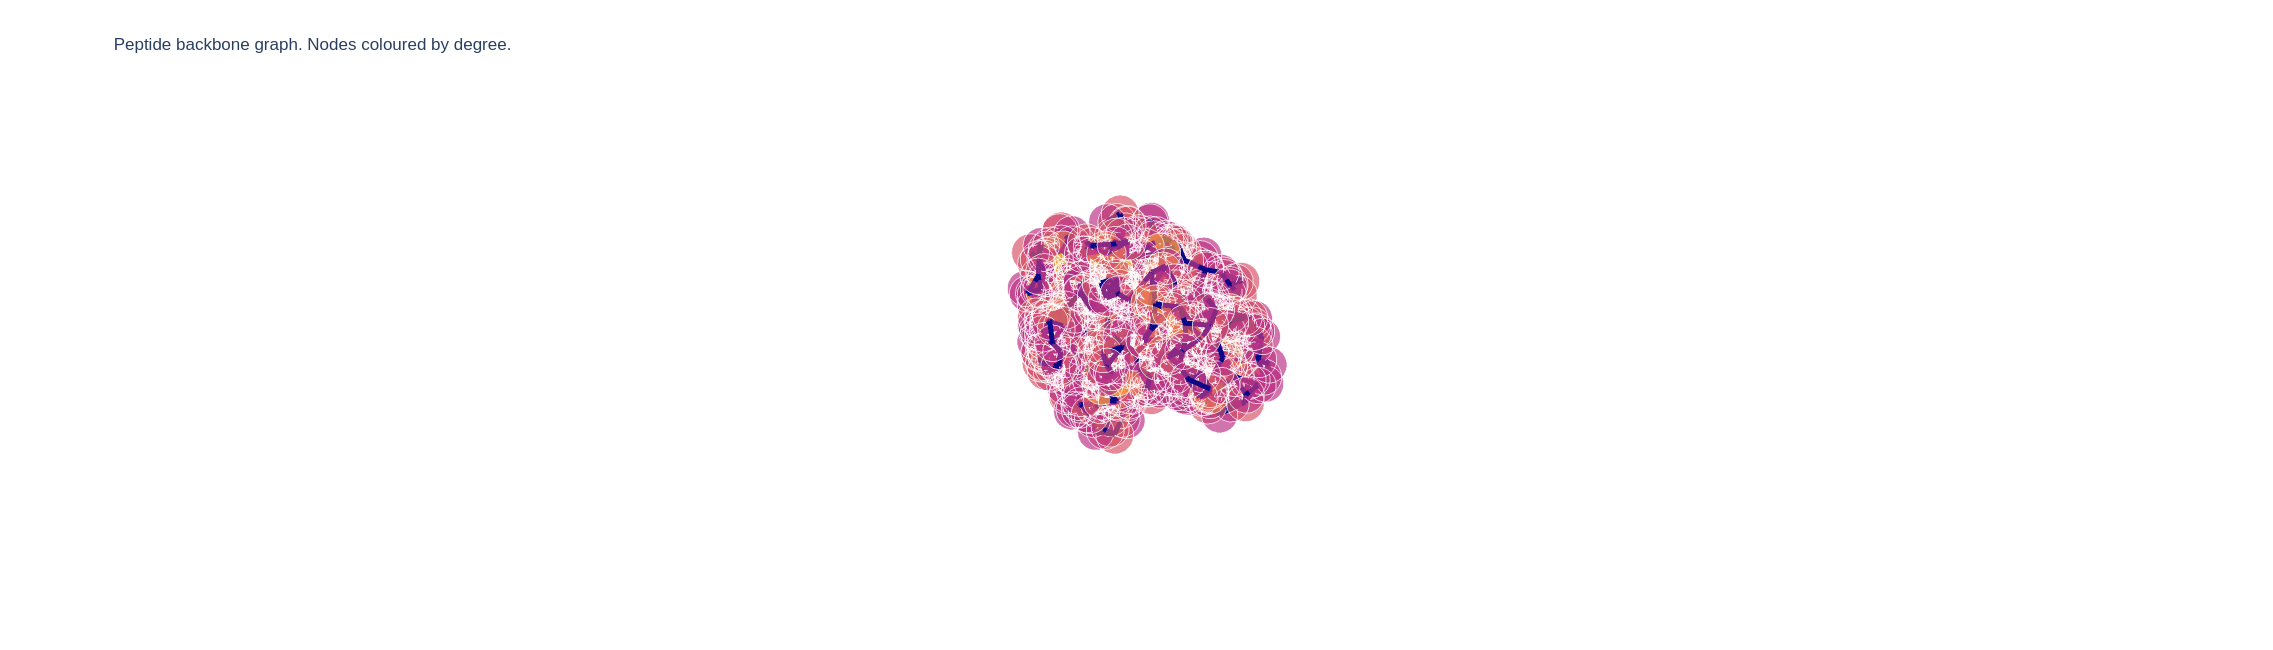

Processing...
  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

[09/20/24 14:34:15] WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=942421;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=476631;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=626612;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=706574;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=341862;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=347347;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=10293;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=505120;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=19716;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=380719;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=604296;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=969955;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=217584;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=279939;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=289562;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=451134;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=652250;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=37457;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=757753;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=882894;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=936735;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=874113;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=770479;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=337376;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=39579;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=633705;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=550497;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=211094;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=443601;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=16556;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=306303;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=880461;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

[09/20/24 14:34:16] WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=130957;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=109151;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=257707;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=450814;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=632617;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=246249;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=484874;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=356229;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=645411;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=138914;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=810973;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=311157;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=599493;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=19152;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=956795;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=555476;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=622039;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=8400;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=134243;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=482852;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=969504;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=333114;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=749550;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=477598;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=517338;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=613061;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=5121;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=959981;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=384546;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=931795;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=978073;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=145989;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=57021;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=834964;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=716765;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=161854;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=557965;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=779596;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=92544;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=851854;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=754034;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=164344;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=479907;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=265699;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=49552;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=742100;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=510082;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=952633;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=263298;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=107717;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=783539;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=735128;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=711325;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=520191;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=212120;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=395639;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=313518;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=405230;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=984976;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=646026;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=802730;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=897785;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=485299;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=599036;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=814232;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=921935;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=446489;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=620410;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=934756;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=498036;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=36635;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=421420;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=118172;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=804144;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=256752;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=663916;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=572153;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=912981;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=795268;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=756570;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=133667;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=979398;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=4082;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=467224;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=860993;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=859437;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=490903;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=647218;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=402585;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=211336;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=979499;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=496771;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=191319;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=987638;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=925864;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=307933;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=256152;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=619682;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=940530;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=101464;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=44683;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=721647;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=970512;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=281172;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=231407;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=206921;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=714252;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=589722;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=553520;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=32224;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=895827;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=219782;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=388752;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=210926;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=196214;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=151127;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=299614;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=361891;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=621882;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=315530;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=458810;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=551802;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=535737;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=421387;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=238206;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=176697;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=550375;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=599561;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=371183;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=920159;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=977660;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=173157;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=186452;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=9684;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=591226;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=276138;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=522968;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=993625;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=759458;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=142369;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=196515;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=746495;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=577304;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=579487;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=818797;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=926205;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=56107;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=965676;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=533978;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=936790;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=791170;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=125753;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=442106;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=204827;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=99754;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=171152;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=219210;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=772876;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=159573;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=209391;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=304905;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=282223;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=276802;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=879611;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=825354;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=259892;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=688949;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=257654;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=454925;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=374210;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=112518;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=425243;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=834874;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=670648;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=984751;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=119684;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=512668;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=906444;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=92184;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=53246;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=759341;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=181140;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=968514;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=384207;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=816865;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=383947;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=291502;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=816141;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=551064;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=405440;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=775787;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=115771;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=390990;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=238847;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=957324;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=147784;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=818765;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=946705;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=103153;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=271356;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=648789;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=101282;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=51728;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=958558;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=949880;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=703758;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=255559;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=820363;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=827965;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=674410;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=887085;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=399936;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=35665;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=676429;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=835041;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=559044;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=703830;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=169702;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=14303;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=476954;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=857683;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=94989;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=144416;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=555522;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=885495;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=895600;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=103420;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=777317;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=210581;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=390800;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=212889;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=545793;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=35250;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=220553;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=421541;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=380567;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=45583;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=158538;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=567157;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=449967;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=444257;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=161459;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=31423;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=927480;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=769932;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=677292;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=268733;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=945254;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=138146;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=701823;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=870395;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=215114;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=265600;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=24990;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=980547;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=473276;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=643291;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=534240;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=299187;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=938526;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=267999;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=539173;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=243313;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=575227;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=242838;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=955219;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=412952;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=388349;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=266767;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=831106;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=823314;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=946269;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=12325;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=755477;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=570287;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=518821;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=369471;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=988840;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=761519;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=434124;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=923533;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=474442;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=325862;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=695088;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=806090;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=858533;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=23779;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=701391;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=662671;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=663366;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=868420;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=153052;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=660172;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=990835;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=859333;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=960760;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=460442;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=885453;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=28597;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=655150;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=482700;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=301342;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=258832;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=991758;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=373461;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=331553;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=17476;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=729248;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=618331;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=489046;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=738431;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=905745;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=71879;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=912435;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=604209;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=462204;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=926587;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=30882;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=616311;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=758935;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=14860;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=864391;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=794267;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=994394;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=491053;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=829836;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=389398;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=14413;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=434947;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=862221;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=459735;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=130924;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=572921;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=836434;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=832281;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=725822;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=399404;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=203308;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=500168;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=247166;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=620229;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=711602;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=389205;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=701115;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=848332;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=831742;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=822578;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=624465;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=915169;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=901635;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=277182;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=338997;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=980727;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=580789;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=204053;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=70260;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=553244;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=408165;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=986750;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=40773;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=11914;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=217938;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=598394;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=792465;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=663193;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=456003;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=183008;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=222016;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=395047;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=60428;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=828644;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=120223;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=472262;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=715293;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=922296;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=368336;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=258279;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=150748;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=526320;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=147289;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=692359;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=773055;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=314123;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=194535;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=527569;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=488218;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=94653;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=349488;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=470138;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=646469;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=846852;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=74282;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=968025;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=454902;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=408188;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=495463;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=259019;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=16911;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=328354;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=826622;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=852242;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=706320;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=29463;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=287165;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=346319;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=570245;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=763751;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=586529;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=513410;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=85853;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=137753;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=490138;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=567950;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=637544;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=303251;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=72226;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=345750;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=75233;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=456607;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=894459;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=936448;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=778592;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=233078;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=139404;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

[09/20/24 14:34:17] WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=956629;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=989254;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=52600;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=802513;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=560953;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=62259;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=775867;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=65346;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=517730;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=33555;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=198857;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=381553;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=209001;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=606890;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=685871;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=942278;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=483389;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=903212;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=930251;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=412672;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=831660;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=428652;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=649188;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=456884;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=664774;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=907289;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=997797;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=933209;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=183114;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=142304;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=481008;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=957282;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=430214;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=764865;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=161303;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=822062;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=616538;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=739137;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=881465;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=108677;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=605707;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=327961;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=859264;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=425264;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=751969;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=772785;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=176222;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=745322;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=476228;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=55865;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=886193;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=245897;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=470625;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=408851;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=500368;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=930459;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=658893;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=268752;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=65952;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=8267;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=592444;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=44436;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=946107;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=278231;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=423362;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=425456;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=149026;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=607523;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=96893;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=276400;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=104769;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=711367;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=861991;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=424189;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=325906;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=802306;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=584942;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=658746;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=498308;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=853270;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=930564;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=457766;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=351057;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=432519;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=955972;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=262742;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=603468;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=262783;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=158847;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=775724;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=80087;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=763158;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=653527;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=84630;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=21903;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=271495;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=279381;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=80451;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=642415;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=290753;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=244564;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=529781;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=789738;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=323832;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=674997;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=141979;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=330784;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=99627;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=40844;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=443177;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=902222;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=8348;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=441088;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=387361;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=816071;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=405881;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=307926;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=301962;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=587462;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=173079;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=59199;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=52622;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=417816;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=860175;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=282844;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=925558;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=793930;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=271690;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=215202;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=281848;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=962944;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=563174;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=984045;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=954645;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=409290;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=850060;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=547792;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=720520;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=965204;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=863154;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=340467;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=323224;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=913395;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=864095;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=178024;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=106899;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=142854;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=938901;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=950276;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=981630;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=431235;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=903460;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=286666;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=833662;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=956463;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=480675;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=853441;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=470097;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=711998;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=688369;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=128530;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=357568;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=85863;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=215647;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=801826;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=510564;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=145242;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=398131;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=117177;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=567538;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=285511;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=1112;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=539609;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=653133;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=36268;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=349594;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=129622;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=662567;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=347633;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=235146;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=202038;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=974076;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=995501;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=775812;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=869882;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=655214;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=928512;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=413401;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=252716;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=570996;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=922205;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=100633;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=136214;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=605309;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=116620;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=984638;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=231720;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=474742;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=730270;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=954071;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=649513;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=995851;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=367850;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=357186;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=581365;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=760237;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=592944;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=569498;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=412929;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=34847;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=334972;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=264837;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=910168;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=904413;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=524983;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=714158;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=190007;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=859209;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=763668;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=226632;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=832586;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=667134;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=236033;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=149973;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=815493;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=250490;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=930719;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=710047;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=34445;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=562391;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=366992;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=896217;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=951008;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=149930;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=108101;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=19695;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=508243;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=108703;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=693392;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=111965;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=506058;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=650754;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=701814;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=952411;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=234112;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=617607;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=633050;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=874205;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=452863;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=604932;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=236125;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=183895;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=552777;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=931105;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=535072;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=471129;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=673816;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=267189;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=291117;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=288352;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=105923;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=82467;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=559985;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=759732;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=12725;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=678137;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=491870;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=650909;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=432147;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=827038;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=439941;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=617109;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=363190;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=747746;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=675540;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=531071;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=309317;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=384049;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=907347;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=811767;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=788083;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=659455;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=767497;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=209977;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=214952;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=319449;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=898055;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=601566;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=112395;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=61882;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=112520;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=298255;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=167240;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=218136;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=701452;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=356837;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=653711;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=657359;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=466924;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=552943;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=708381;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=334966;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=595466;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=923079;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=443935;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=227992;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=748704;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=382179;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=580953;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=774123;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=318258;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=913253;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=137866;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=346842;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=87409;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=821759;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=872295;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=126211;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=930973;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=664504;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=493476;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=663906;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=82460;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=940726;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=789350;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=653990;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=707149;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=89920;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=220046;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=516521;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=271826;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=654651;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=38417;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=283187;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=715734;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=187820;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=960323;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=33788;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=677872;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=242850;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=664565;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=372136;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=991836;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=798801;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=548088;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=747100;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=590483;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=140151;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=690631;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=604927;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=856934;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=198559;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=664652;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=6062;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=358507;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=488123;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=17752;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=341094;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=36303;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=61898;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=731207;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=230318;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=637827;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=156486;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=34991;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=143092;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=872187;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=39897;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=951554;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=291501;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=598946;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=458380;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=105740;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=762425;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=998593;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=143449;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=797479;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=322911;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=283599;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=133427;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=499821;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=481586;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=373529;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=920232;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=960101;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=132002;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=309849;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=674267;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=605091;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=334468;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=391815;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=948980;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=208979;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=881703;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=438316;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=893485;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=586369;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=619151;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=4560;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=44639;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=780116;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=119489;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=729092;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=412558;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=433456;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=104499;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=546791;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=773405;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=101553;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=350053;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=41430;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=939701;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=848674;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=600504;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=210559;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=741289;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=200828;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=630087;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=737616;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=878152;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=577175;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=307090;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=906223;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=781305;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=477168;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=762854;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=477268;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=932560;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=593346;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=529625;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

[09/20/24 14:34:18] WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=985060;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=907268;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=331268;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=488676;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=210231;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=778179;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=617011;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=816415;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=89603;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=397237;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=90632;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=989219;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=263596;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=956826;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=506622;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=204894;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=243773;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=539564;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=173485;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=138874;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=986173;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=231559;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=886410;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=858998;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=627192;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=249586;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=69795;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=823136;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=821922;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=991278;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=356039;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=967061;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=674539;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=831524;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=98298;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=971585;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=124707;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=384578;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=184994;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=523029;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=312680;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=316368;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=713762;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=566361;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=117567;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=524757;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=612755;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=198903;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=974031;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=981829;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=514444;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=929585;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=166591;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=370936;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=60324;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=171704;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=677448;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=799154;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=402315;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=13338;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=511674;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=19137;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=484118;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=475914;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=115630;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=386316;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=393219;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=788177;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=415592;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=41064;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=330441;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=693857;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=283320;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=993594;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=89986;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=78603;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=961127;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=648360;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=668519;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=100538;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=528934;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=396699;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=639824;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=886435;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=555171;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=688026;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=225216;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=816563;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=328008;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=756164;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=187418;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=180007;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=165535;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=442288;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=991004;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=763523;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=245165;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=8785;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=492315;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=750680;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=850719;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=806933;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=435776;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=486737;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=598783;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=289211;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=548998;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=223533;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=881051;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=35362;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=266278;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=158764;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=763062;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=333429;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=804864;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=876758;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=87535;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=848837;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=275818;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=210832;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=147207;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=111805;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=786373;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=345986;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=241662;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=775447;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=347648;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=364107;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=237701;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=287758;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=908561;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=794543;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=820362;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=584949;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=650291;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=532871;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=331547;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=370220;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=384811;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=130543;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=48032;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=991351;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=908563;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=203294;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=523152;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=679474;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=679289;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=483371;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=105186;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=954009;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=392356;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=205466;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=531288;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=755910;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=582050;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=414032;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=832688;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=75680;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=482701;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=352412;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=532644;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=850878;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=387347;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=339788;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=445279;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=853838;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=278976;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=422414;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=401429;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=208065;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=145841;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=214789;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=369492;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=855389;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=545308;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=865561;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=881882;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=554868;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=144837;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=305520;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=868220;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=296102;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=619825;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=515096;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=893375;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=291658;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=499984;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=715991;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=281990;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=738415;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=376371;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=687423;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=919763;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=455307;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=249824;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=217713;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=612475;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=901032;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=902956;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=607646;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=339099;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=511519;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=337964;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=315476;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=686045;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=802324;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=287664;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=934489;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=680849;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=124992;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=358792;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=511946;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=143424;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=78547;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=636944;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=665244;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=445146;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=228603;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=602255;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=833022;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=233771;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=745868;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=701716;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=815767;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=832022;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=814505;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=323690;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=555925;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=858503;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=393539;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=659461;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=279366;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=744854;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=352616;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=744444;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=226936;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=519869;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=952417;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=495548;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=183676;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=650609;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=166712;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=136398;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=813295;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=689126;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=288452;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=461344;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=527710;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=550151;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=714389;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=908188;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=188782;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=583012;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=763006;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=950655;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=414806;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=101468;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=181872;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=948603;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=819432;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=778260;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=329930;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=483049;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=478999;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=436147;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=218531;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=954405;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=931928;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=304994;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=296884;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=698053;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=768442;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=509776;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=406619;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=976895;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=354060;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=151019;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=355598;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=907335;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=964309;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=403336;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=376408;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=7819;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=555714;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=417339;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=604583;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=75176;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=804736;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=673959;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=320131;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=560862;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=153794;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=516905;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=293834;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=645184;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=890063;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=263943;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=453808;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=185666;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=717470;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=709258;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=216593;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=220554;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=705511;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=915834;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=824033;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=95308;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=918814;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=668764;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=85237;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=639939;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=565170;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=271665;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=73568;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=254934;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=595707;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=136971;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=482893;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=909398;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=87904;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=494663;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=925801;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=822147;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=416764;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=353078;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=962276;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=861671;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=227742;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=24084;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=677307;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=523188;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=975603;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=203770;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=118192;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=719678;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=776176;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=412568;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=148062;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=686214;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=838885;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=892208;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=293106;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=54905;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=100846;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=235347;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=675725;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=678520;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=648205;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=325492;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=849197;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=363126;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=931886;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=383782;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=628176;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=274937;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=989357;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=13735;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=762179;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=54162;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=855649;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=226578;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=731263;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=278664;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=137231;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=961167;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=699569;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=774137;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=220976;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=26423;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=508949;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=515565;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=589126;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=126368;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=862115;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=781678;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=93637;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=461383;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=6178;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=179551;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=841053;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=697085;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=332330;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=972952;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=832579;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=967379;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=844670;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=935717;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=343569;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=685429;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=528320;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=437678;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=866189;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=160796;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=980001;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=364473;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=757690;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=350812;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=992702;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=815903;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=303393;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=404384;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=677408;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=974555;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=574510;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=844119;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=514331;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=745133;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=807724;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=485846;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=437435;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=183234;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=645834;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=164787;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=766515;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=567855;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=521646;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=791766;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=958206;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=178015;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=891182;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=346318;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=898460;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=555186;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=756555;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=369235;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=987672;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=429111;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=3892;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=90373;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=362104;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=365369;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=809936;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=357218;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=226133;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=640074;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=502481;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=875315;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=518614;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=495168;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=405636;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=111315;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=745778;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=609290;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=270660;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=40976;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=144237;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=288599;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=891731;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=278239;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=806191;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=623008;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=42068;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=269763;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=209555;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=252370;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=409856;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=191632;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=358517;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=97148;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=438693;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=163361;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=760393;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=799800;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=460664;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=94639;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=803984;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=716039;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=732909;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=624532;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=151719;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=852435;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=988569;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=406311;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=243211;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

[09/20/24 14:34:19] WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=838245;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=766860;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=310499;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=662344;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=791101;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=68675;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=8409;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=641773;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=88339;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=890734;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=884686;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=821139;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=224194;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=432234;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=349952;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=215399;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=444180;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=196617;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=574764;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=803708;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=175678;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=493940;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=523915;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=605635;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=360931;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=966782;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=487251;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=280735;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=619342;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=701679;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=501691;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=288947;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=485665;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=839804;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=523153;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=962956;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=238574;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=842769;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=930716;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=685642;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=548638;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=98892;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=877827;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=491234;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=762103;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=996642;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=455493;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=863286;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=671425;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=814533;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=591375;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=516845;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=168959;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=863183;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=330494;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=993473;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=590722;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=778349;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=279273;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=647813;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=794699;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=938125;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=230698;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=797048;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=407077;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=76345;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=73966;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=350945;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=267356;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=558424;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=838380;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=48538;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=231543;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=172971;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=619981;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=827187;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=757480;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=291602;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=927168;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=765662;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=547419;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=877509;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=409619;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=464860;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=56246;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=204549;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=29283;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=198539;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=457094;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=556101;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=941612;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=24933;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=233493;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=500996;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=53731;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=983871;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=687443;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=581500;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=809701;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=211680;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=547340;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=459341;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=300612;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=808903;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=303981;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=596583;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=115487;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=227361;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=228836;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=527044;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=541320;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=592048;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=677349;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=34328;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=979973;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=521490;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=603690;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=38691;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=70521;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=265504;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=128224;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=80888;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=642107;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=590411;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=905803;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=346793;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=281589;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=225400;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=118111;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=66100;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=491542;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=442384;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=409958;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=262040;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=896368;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=103084;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=143343;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=701295;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=263735;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=416726;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=819192;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=552472;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=951132;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=937691;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=854908;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=447554;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=152071;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=104326;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=515670;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=644866;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=671535;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=338678;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=652996;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=34066;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=58678;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=4233;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=128914;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=26088;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=65332;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=399693;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=988473;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=840539;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=840322;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=854036;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=529829;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=49764;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=866257;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=468056;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=704266;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=198645;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=632180;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=443725;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=692853;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=769014;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=466979;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=518923;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=900204;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=249129;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=963407;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=210788;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=488781;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=427646;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=107015;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=44066;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=508131;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=606746;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=567088;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=740657;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=487081;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=758543;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=582199;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=582017;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=760473;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=950861;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=454961;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=803271;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=907781;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=857523;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=920001;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=31190;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=463057;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=335246;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=339717;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=74954;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=269396;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=996122;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=374027;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=480534;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=156207;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=827472;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=718598;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=215777;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=33282;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=233472;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=589676;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=918709;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=240711;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=50818;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=291241;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=739991;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=710737;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=849801;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=205612;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=646396;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=719176;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=613816;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=367529;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=792887;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=574258;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=769911;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=974425;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=940680;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=736865;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=460368;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=790230;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=128726;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=195938;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=676135;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=497707;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=897646;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=576460;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=481816;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=905783;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=691835;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=976600;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=356442;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=726232;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=436075;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=644784;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=268835;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=865364;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=217228;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=877983;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=853608;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=593146;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=797327;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=948627;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=311916;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=221394;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=980451;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=767122;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=336560;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=228200;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=743564;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=369726;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=482464;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=292476;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=258548;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=22271;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=510262;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=643677;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=530263;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=686315;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=384832;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=425035;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=797263;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=516817;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=589591;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=301418;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=798571;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=341846;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=794393;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=482441;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=165923;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=568058;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=821823;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=175044;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=846806;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=358214;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=738113;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=693347;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=463527;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=774181;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=176391;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=425587;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=603465;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=377513;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=54744;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=509904;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=250222;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=198404;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=783296;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=440910;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=572403;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=266746;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=833471;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=158420;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=326315;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=273387;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=441406;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=938033;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=512452;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=131161;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=646188;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=878475;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=956824;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=325326;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=686064;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=217985;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=649811;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=977946;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=899451;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=824052;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=353923;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=142394;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=539951;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=793256;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=16759;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=829470;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=919504;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=976366;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=40279;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=774812;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=910755;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=927227;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=121352;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=90607;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=242173;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=871204;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=524734;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=395778;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=892801;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=269544;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=345583;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=300225;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=872980;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=375906;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=464058;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=225374;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=495367;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=28188;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=447253;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=261458;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=636280;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=504721;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=996913;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=86046;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=796273;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=135514;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=789853;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=199420;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=641864;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=660525;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=71862;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=977037;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=246739;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=646617;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=291355;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=824854;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=500165;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=27500;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=555853;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=265017;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=7164;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=41912;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=153511;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=156625;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=807075;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=548792;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=455227;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=329465;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=560309;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=433069;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=354537;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=645182;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=298870;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=210129;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=139044;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=344232;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=401683;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=556211;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=736997;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=225296;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=374138;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=495588;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=350170;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=205885;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=241540;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=712966;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=344000;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=872333;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=527986;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=986042;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=403790;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=959079;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=712134;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=204991;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=813100;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=277219;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=952143;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=739745;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=682623;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=101247;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=97028;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=704250;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=985915;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=165991;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=975343;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=389490;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=514004;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=300951;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=634608;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=859359;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=521708;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=643008;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=388686;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=614453;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=49935;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=805021;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=344151;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=672450;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=373350;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

[09/20/24 14:34:20] WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=576399;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=832206;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=151574;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=430458;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=233537;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=688801;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=441611;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=40077;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=508432;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=1037;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=956509;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=252460;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=586540;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=690702;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=106091;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=671993;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=690500;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=250948;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=662367;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=587723;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=358458;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=802795;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=414274;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=836340;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=715603;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=874282;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=939369;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=350934;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=184558;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=465457;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=368549;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=671731;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=873769;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=624613;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=787368;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=960709;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=8105;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=678476;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=225325;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=249351;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=465177;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=79736;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=553654;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=167636;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=423675;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=127706;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=997631;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=134310;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=413377;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=47441;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=467005;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=196938;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=312834;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=408904;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=332009;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=808635;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=930842;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=266584;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=246857;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=679226;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=368847;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=468968;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=200133;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=85589;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=105543;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=778829;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=347801;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=320723;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=293871;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=117912;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=421187;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=201658;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=123268;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=701335;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=864150;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=218532;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=936145;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=42438;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=241362;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=386698;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=312503;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=167440;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=279352;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=626715;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=842816;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=153014;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=246446;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=26928;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=904686;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=624452;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=53246;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=54623;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=783863;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=396314;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=463915;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=267665;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=807698;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=813984;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=426245;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=612247;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=616483;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=826912;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=57268;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=892721;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=63246;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=166247;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=135822;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=775545;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=361682;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=924952;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=906489;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=270427;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=67359;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=269060;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=944756;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=383870;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=922520;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=492511;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=852374;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=408311;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=855670;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=13320;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=78189;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=103407;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=164395;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=492151;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=251941;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=846474;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=478182;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=771241;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=210274;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=457503;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=286377;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=86493;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=606631;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=807915;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=71392;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=116577;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=669498;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=311326;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=424130;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=679371;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=675714;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=7079;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=344933;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=576110;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=630668;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=508494;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=325830;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=214853;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=496053;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=507814;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=913879;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=603276;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=837097;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=657386;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=531861;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=479799;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=401730;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=308003;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=119128;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=718260;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=902531;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=125455;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=902806;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=761512;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=709960;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=94201;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=912177;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=108475;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=73637;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=384259;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=749716;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=688900;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=505644;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=172626;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=955320;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=418274;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=411471;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=210443;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=461873;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=114053;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=469291;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=622450;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=198013;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=906174;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=718635;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=191247;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=413689;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=299585;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=987663;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=845058;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=147789;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=260289;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=771221;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=501774;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=269300;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=185018;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=284545;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=235239;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=684817;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=420242;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=181639;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=767983;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=135012;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=862960;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=814204;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=333142;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=604396;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=716948;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=595949;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=658657;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=545923;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=282477;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=267156;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=969523;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=3108;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=703853;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=560250;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=661906;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=40224;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=408356;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=711947;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=133241;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=21757;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=533554;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=700174;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=367763;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=155758;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=176774;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=782745;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=164734;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=116658;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=448888;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=842109;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=243614;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=888641;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=7591;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=210985;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=967406;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=634673;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=5610;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=13494;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=494939;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=775455;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=637448;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=527900;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=310960;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=930197;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=713474;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=670603;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=652015;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=68575;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=316107;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

[09/20/24 14:34:21] WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=424751;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=111792;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

 50%|██████████████████████▌                      | 1/2 [00:28<00:28, 28.56s/it]

  0%|          | 0/112 [00:00<?, ?it/s]

[09/20/24 14:34:45] WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=250804;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=778426;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=329450;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=814652;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=919198;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=709025;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=465358;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=873484;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=203834;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=142095;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=393372;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=561792;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=170610;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=488922;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=643982;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=719904;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=908486;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=506113;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=130734;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=44016;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=977490;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=673671;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=352077;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=300864;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=258389;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=16697;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=413031;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=75809;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=407830;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=62113;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=579068;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=600775;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=677772;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=140408;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=524996;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=29864;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=435343;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=73735;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=216480;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=887625;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=244946;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=616950;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=128411;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=837763;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=142937;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=686655;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=145206;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=854806;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=699806;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=798307;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=137513;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=786791;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=769497;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=932902;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=115664;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=332530;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=363010;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=360342;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=703522;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=213493;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=889639;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=114075;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=754315;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=802813;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=439005;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=268163;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=582800;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=460763;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=814172;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=473815;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=101352;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=954118;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=634716;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=672440;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=966084;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=435282;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=906059;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=245407;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=341988;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=756411;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=931681;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=585165;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=29156;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=725658;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=902820;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=626168;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=692135;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=18141;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=178874;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=557634;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=391630;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=887886;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=143907;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=382175;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=851199;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=14591;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=837000;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=190349;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=823125;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=172255;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=389118;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=293184;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=466009;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=828712;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=587027;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=812812;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=743872;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=280438;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=259036;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=404793;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=222296;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=389712;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=149723;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=463338;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=620137;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=14317;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=530540;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=691232;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=407675;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=184827;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=676296;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=966270;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=469325;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=358599;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=506508;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=24914;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=831163;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=526993;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

[09/20/24 14:34:46] WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=630898;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=815406;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=723325;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=929016;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=317127;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=279106;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=769527;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=297943;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=870839;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=522616;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=854532;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=88381;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=700763;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=701596;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=281445;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=169466;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=560167;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=690189;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=269721;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=203475;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=787677;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=147062;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=763218;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=647559;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=698194;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=461436;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=510070;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=944868;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=949785;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=634229;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=830168;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=498691;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=729842;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=222502;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=495818;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=55054;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=889995;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=148281;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=721429;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=952902;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=233583;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=810340;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=283212;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=269531;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=73251;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=525520;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=451452;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=244285;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=619491;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=997634;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=396597;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=787878;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=74577;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=90513;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=924836;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=421777;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=667795;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=725108;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=899868;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=721269;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=345402;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=273964;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=850192;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=583317;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=816003;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=98443;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=16687;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=260319;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=355644;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=702807;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=486022;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=623220;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=860651;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=58101;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=490795;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=825657;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=52100;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=896475;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=497561;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=59810;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=635327;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=625419;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=785959;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=587629;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=762476;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=929868;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=94946;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=508046;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=124618;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=684612;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=409695;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=485776;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=682425;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=702774;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=84194;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=264090;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=936485;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=237300;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=440914;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=907936;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=232829;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=265645;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=628383;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=978498;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=495224;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=881434;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=670886;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=646659;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=480519;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=933739;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=325999;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=100715;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=32943;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=426371;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=295554;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=554346;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=689712;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=951930;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=726834;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=135843;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=853972;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=830100;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=16620;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=398042;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=21981;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=724950;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=666915;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=169443;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=977680;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=972503;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=687857;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=383608;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=576696;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=697973;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=581348;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=868651;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=702714;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=34696;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=726768;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=169412;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=764779;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=921972;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=892737;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=298501;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=764312;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=4066;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=940031;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=384600;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=168877;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=441243;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=665289;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=582219;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=222721;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=871072;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=344955;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=43844;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=417469;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=904966;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=532555;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=595009;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=245103;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=762509;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=795293;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=891730;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=745275;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=34560;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=312888;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=37982;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=583317;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=738147;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=785586;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=293066;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=646502;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=941977;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=492293;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=885056;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=115369;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=72230;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=507803;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=66253;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=776715;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=547225;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=915019;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=948955;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=512499;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=21414;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=245791;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=527967;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=115837;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=460679;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=984592;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=616896;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=940048;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=539343;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=210215;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=475821;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=76772;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=78503;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=812142;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=533789;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=323409;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=614316;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=588794;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=871120;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=658918;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=790708;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=906850;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=56039;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=528330;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=332538;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=332946;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=243117;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=399486;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=671193;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=149499;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=685607;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=833591;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=255613;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=385871;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=525989;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=812050;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=897936;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=856432;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=696069;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=870094;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=503335;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=501363;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=258457;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=318764;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=787543;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=912498;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=409357;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=724813;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=286594;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=742221;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=22891;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=815620;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=416245;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=873376;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=405836;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=170542;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=926733;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=806768;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=939636;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=515122;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=705214;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=625079;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=476803;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=563513;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=973293;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=448360;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=398085;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=414929;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=80491;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=227179;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=812723;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=420722;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=281679;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=535247;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=497952;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=166843;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=179356;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=214045;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=851606;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=223905;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=864834;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=871771;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=539702;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=775426;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=38298;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=286615;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=217895;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=539663;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=939125;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=361759;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=444926;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=286905;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=280253;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=111570;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=862324;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=853206;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=224013;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=949819;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=522643;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=26654;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=340546;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=209894;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=693880;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=121923;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=68971;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=200299;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=822318;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=925526;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=107433;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=399516;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=413719;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=886411;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=318566;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=434989;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=220805;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=479908;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=634266;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=721781;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=796370;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=819594;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=514165;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=152600;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=603152;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=608976;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=168275;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=200737;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=479761;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=53437;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=669716;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=673234;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=528091;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=417602;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=655767;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=951702;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=839601;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=410492;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=982923;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=689304;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=110436;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=669406;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=708081;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=316129;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=89636;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=46026;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=797864;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=524375;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=44342;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=859602;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=768158;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=560401;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=684633;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=851515;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=56530;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=826777;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=311470;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=795601;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=671265;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=116657;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=897181;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=812264;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=737997;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=498407;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=446377;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=367384;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=411860;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=847911;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=664445;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=392289;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=643803;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=429727;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=665526;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=418934;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=127771;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=658254;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=805474;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=830666;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=738930;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=940594;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=26850;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=240951;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=287478;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=599707;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=964784;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=102842;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=836641;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=921770;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=216509;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=860961;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=938192;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=538075;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=496782;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=152340;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=757147;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=983524;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=666465;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=537701;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=54169;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=665978;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=290332;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=203112;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=347496;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=981267;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=366527;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=768010;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=107667;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=933850;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=337200;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=19994;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=406528;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=821919;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=632636;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=194889;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=476183;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=626901;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=173593;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=537494;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=175942;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=469911;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=835559;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=937380;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=108724;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=195911;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=405302;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=235811;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=532152;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=155423;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=610915;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=101344;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=30119;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=488914;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=760755;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=543520;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=352727;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=764432;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=751899;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=690284;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=298488;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=598932;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=772306;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=883546;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=932521;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=820740;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=279237;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=216477;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=446067;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=574595;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=227374;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=246839;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=444951;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=788488;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=511014;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=310449;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=911379;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=453129;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=279825;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=254914;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=602034;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=130554;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=629566;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=79548;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=441513;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=327714;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=649482;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=145107;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=828941;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=627109;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=917321;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=424543;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=626110;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=358372;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=78721;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=345938;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=931830;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=876865;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=767794;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=493852;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=863344;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=214808;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=629910;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=487433;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=496433;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=117234;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=127554;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=533891;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=866487;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=442166;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=745640;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=671105;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=132714;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=375677;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=852888;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=23963;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=49816;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

[09/20/24 14:34:47] WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=654861;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=255821;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=183957;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=48561;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=966119;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=956881;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=436915;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=614323;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=968850;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=54179;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=667396;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=404457;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=164507;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=993558;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=302653;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=744866;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=681096;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=909669;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=583148;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=98742;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=623711;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=982014;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=703083;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=552497;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=995501;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=947485;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=726302;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=742159;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=845625;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=819002;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=139895;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=148046;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=668474;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=947662;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=216667;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=700765;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=258190;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=741722;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=90182;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=496625;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=157797;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=711143;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=297360;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=376959;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=885266;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=553030;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=246476;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=111998;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=405090;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=81451;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=762953;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=380179;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=952559;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=903584;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=762279;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=206793;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=818377;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=986172;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=860450;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=229676;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=228934;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=207585;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=162820;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=259142;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=538672;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=552753;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=734322;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=90132;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=585081;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=525228;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=576047;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=883451;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=600740;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=782806;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=852952;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=457449;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=45473;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=199489;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=979897;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=52887;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=87653;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=204812;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=598277;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=825503;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=895557;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=998564;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=814416;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=881746;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=561918;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=494874;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=488209;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=828708;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=767480;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=844545;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=746176;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=300756;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=888317;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=852056;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=419075;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=455212;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=623977;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=87892;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=234352;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=911789;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=680819;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=263467;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=847715;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=222313;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=44108;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=867840;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=780650;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=489865;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=517364;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=551792;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=534441;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=764922;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=602923;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=763187;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=747257;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=199571;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=790712;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=206364;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=252580;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=664588;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=993904;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=877708;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=573288;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=172589;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=812422;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=24724;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=829295;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=173915;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=246147;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=523648;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=362258;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=315653;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=786430;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=274670;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=743807;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=533767;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=126313;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=869367;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=103991;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=220693;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=77544;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=285177;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=274372;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=152138;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=41515;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=592466;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=228875;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=391906;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=983682;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=423082;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=347099;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=539086;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=66418;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=639532;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=97723;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=949600;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=154454;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=530845;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=831993;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=562189;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=357308;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=236909;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=309652;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=418528;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=373824;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=415146;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=374804;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=495652;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=716268;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=748000;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=871655;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=565899;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=662058;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=980918;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=300670;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=590130;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=974553;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=432712;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=345230;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=698118;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=519569;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=242546;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=191126;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=947307;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=364684;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=601319;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=606727;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=69438;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=412857;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=436468;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=141832;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=594209;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=385181;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=841587;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=517623;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=516594;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=431931;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=868987;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=901184;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=923894;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=583005;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=483276;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=52981;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=66752;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=934304;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=617030;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=45864;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=765862;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=652484;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=776089;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=636145;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=941457;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=208895;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=673890;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=270679;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=139925;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=685422;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=381582;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=405135;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=747267;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=119162;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=752742;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=829065;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=957488;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=331979;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=738594;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=401364;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=782134;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=857405;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=773269;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=72963;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=276264;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=695733;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=668319;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=826520;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=827038;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=941120;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=35132;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=330808;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=11266;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=186132;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=705204;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=771953;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=698460;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=430980;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=718149;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=594499;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=62544;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=296874;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=96390;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=393445;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=950038;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=883006;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=963342;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=139367;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=263774;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=359177;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=286091;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=896;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=492947;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=683957;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=172541;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=857264;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=889634;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=540871;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=896878;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=805572;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=802502;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=829878;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=548362;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=923953;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=320418;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=662723;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=303662;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=995676;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=494117;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=524415;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=266222;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=258496;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=422611;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=543521;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=501956;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=623527;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=643138;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=119833;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=848646;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=189872;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=153207;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=131735;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=404910;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=143584;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=734341;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=553496;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=695861;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=628114;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=520258;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=700516;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=27071;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=245474;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=950043;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=240132;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=855933;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=286686;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=203838;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=25512;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=808965;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=493948;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=3428;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=145662;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=45072;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=538593;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=621062;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=271131;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=93099;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=849900;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=492791;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=518999;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=177029;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=215529;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=257121;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=439554;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=501365;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=479503;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=897126;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=897166;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=272015;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=51194;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=743384;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=22634;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=16556;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=46137;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=186125;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=319557;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=197299;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=648292;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=493779;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=823654;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=902102;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=510891;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=977560;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=336244;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=300541;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=481877;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=282701;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=469894;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=526075;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=174990;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=768298;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=238514;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=52023;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=114941;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=101511;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=273425;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=583166;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=252618;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=886403;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=731187;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=660782;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=647824;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=983932;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=364492;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=211664;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=192122;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=898701;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=190475;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=923154;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=905231;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=465000;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=911675;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=27293;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=325786;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=853587;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=491416;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=338804;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=391592;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=66401;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=726284;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=888147;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=768287;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=386555;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=126054;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=259304;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=846197;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=153702;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=139589;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=596728;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=481017;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=157947;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=500395;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=587160;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=880986;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=868568;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=674541;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=788961;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=179991;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=233506;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=264880;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=889874;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=899288;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=288203;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=152641;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=413684;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=615890;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=340705;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=26369;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=90154;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=472037;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=681099;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=798864;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=593183;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=860568;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=193930;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=912891;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=931489;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=332478;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=990813;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=766449;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=594224;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=997616;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=620823;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=467459;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=116531;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=10751;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=672843;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=817085;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=127972;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=360733;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=337190;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=556694;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=962914;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=639903;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=842270;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=832299;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=305719;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=944018;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=187684;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=383809;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=487160;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=947348;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=507054;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=540506;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=166554;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=315009;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=641133;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=984439;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=124646;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=616542;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=677754;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=659419;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=540819;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=590764;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=585733;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=617453;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=387658;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=568646;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=776956;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=206424;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=553326;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=291720;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=707783;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=906035;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=27504;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=908495;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=243809;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=10107;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=309092;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=289011;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=248971;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=116298;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=906234;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=366673;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=650685;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=91777;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=133367;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=439361;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=82120;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=270107;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=89746;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=386934;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=413938;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=591379;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=495515;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=207272;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=273507;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=980313;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=8601;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=496409;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=818940;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=132314;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=6108;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=977712;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=404214;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=367594;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=705521;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

[09/20/24 14:34:48] WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=387062;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=100585;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=749453;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=158614;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=229469;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=610228;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=368693;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=740746;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=267905;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=31327;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=730944;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=581579;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=176305;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=556074;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=809461;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=576351;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=53930;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=3629;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=937853;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=545978;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=100539;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=521672;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=543097;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=555805;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=756598;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=671445;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=11744;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=527136;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=210972;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=509867;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=371020;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=829752;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=712065;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=597779;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=632629;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=135616;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=628344;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=958962;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=525075;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=634376;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=479384;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=705508;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=19653;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=381141;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=969985;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=898458;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=894616;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=608576;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=231418;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=883696;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=410431;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=995043;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=468182;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=253116;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=559090;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=578390;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=223070;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=816960;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=988801;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=185046;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=305656;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=334977;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=154304;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=532177;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=857760;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=918323;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=357017;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=338563;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=76625;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=749066;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=276520;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=847686;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=191762;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=883507;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=396452;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=238057;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=721945;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=280168;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=91390;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=700732;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=873644;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=85280;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=900787;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=765034;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=515524;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=637958;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=324837;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=78138;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=729347;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=576048;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=938924;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=79803;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=668559;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=978021;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=523303;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=837771;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=418994;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=7410;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=643410;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=221467;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=366450;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=138499;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=126037;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=322123;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=33579;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=145864;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=768306;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=693320;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=549337;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=915601;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=269618;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=43197;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=348797;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=697388;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=135282;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=564834;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=735952;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=583069;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=858858;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=912633;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=693808;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=430716;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=730143;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=305397;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=286472;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=448020;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=456559;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=496446;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=403068;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=626331;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=808294;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=62281;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=544455;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=929981;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=614218;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=809480;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=28404;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=824241;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=983233;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=745932;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=72910;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=619061;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=243045;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=38538;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=679337;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=302086;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=659568;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=748066;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=193932;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=614973;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=840920;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=473354;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=179494;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=148311;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=591344;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=845216;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=582593;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=596274;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=296602;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=462682;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=331967;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=181572;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=940967;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=512508;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=67293;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=623528;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=866793;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=127535;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=75343;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=266954;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=509033;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=581579;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=490248;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=228012;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=418224;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=390737;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=962582;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=909539;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=605457;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=219824;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=158776;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=402938;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=756311;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=814910;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=761043;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=453361;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=433573;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=33064;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=315778;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=224315;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=731921;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=943227;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=314020;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=608107;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=455876;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=124302;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=436115;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=192764;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=844078;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=952630;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=289266;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=92237;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=913933;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=309482;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=179512;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=861497;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=35191;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=447577;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=232483;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=566995;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=680296;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=998810;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=884636;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=927877;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=145957;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=992579;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=937393;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=26415;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=141775;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=588500;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=824734;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=639953;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=685632;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=137729;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=752703;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=59922;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=110413;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=116476;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=471818;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=326711;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=953917;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=11718;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=439700;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=137808;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=533227;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=852319;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=27599;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=374307;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=829151;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=324823;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=893129;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=640716;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=64926;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=945821;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=773815;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=491;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=475573;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=135104;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=961894;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=21881;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=954788;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=321813;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=598654;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=663431;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=610842;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=533081;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=982002;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=626507;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=972544;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=300305;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=492488;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=438094;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=139683;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=256210;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=687133;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=209569;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=12028;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=679959;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=263158;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=485060;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=611465;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=97890;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=366864;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=934582;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=50938;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=733541;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=308087;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=269590;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=79767;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=969382;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=165443;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=547225;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=998738;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=950285;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=133991;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=636181;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=452578;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=245926;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=540023;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=518026;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=733121;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=255829;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=48912;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=81539;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=84311;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=940713;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=176237;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=413369;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=848708;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=823830;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=914033;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=538015;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=633412;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=733997;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=91367;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=586506;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=290246;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=968354;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=613000;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=747197;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=425829;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=852681;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=269874;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=400285;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=662901;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=467960;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=998854;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=112230;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=96647;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=386322;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=646299;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=153177;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=477797;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=512183;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=231425;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=794219;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=41672;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=971086;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=84121;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=369129;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=479094;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=813020;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=619417;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=10996;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=342026;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=721499;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=303593;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=90392;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=381762;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=609944;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=144371;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=294312;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=287617;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=637165;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=675955;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=333654;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=300715;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=365882;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=785909;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=147457;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=663473;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=290102;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=749040;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=798486;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=395953;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=435194;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=459742;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=848155;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=804759;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=404659;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=564408;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=404241;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=928410;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=119035;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=172197;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=355815;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=800798;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=507919;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=940725;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=475726;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=999044;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=133713;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=446089;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=455147;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=39708;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=509146;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=677201;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=661404;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=109797;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=539110;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=462271;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=810250;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=849920;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=698035;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=650084;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=956056;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=302213;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=285490;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=531847;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=177344;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=532339;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=352530;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=792958;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=427151;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=355177;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=236568;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=457962;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=917493;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=798232;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=717440;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=664549;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=549548;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=298847;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=597477;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=622516;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=661731;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=504385;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=188803;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=671484;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=732430;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=33392;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=798076;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=749181;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=505309;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=694025;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=115048;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=981718;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=259228;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=935022;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=112046;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=387856;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=93406;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=831640;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=775764;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=464548;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=482540;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=679642;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=590972;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=490282;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=550149;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=966871;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=606518;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=122668;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=258690;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=340351;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=587817;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=512618;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=732866;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=870496;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=722863;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=634613;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=483210;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=66918;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=868535;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=158686;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=24540;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=446524;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=942421;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=638819;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=543253;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=133649;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=617972;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=400245;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=928442;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=342423;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=184504;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=386434;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=97931;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=214615;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=651505;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=151205;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=792606;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=504506;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=500890;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=102786;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=289508;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=143284;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=117723;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=707855;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=434633;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=919603;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=26155;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=414954;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=411356;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=616839;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=878803;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=135587;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=92894;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=158408;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=699134;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

[09/20/24 14:34:49] WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=190129;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=732934;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=253177;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=193489;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=789695;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=227348;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=405724;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=87579;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=761390;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=992840;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=47499;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=29239;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=5575;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=623982;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=853292;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=882644;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=137769;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=845638;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=436818;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=820174;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=596298;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=604196;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=323514;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=167308;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=902898;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=298542;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=392940;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=741487;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=463111;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=39215;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=159069;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=117472;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=764726;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=528452;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=619659;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=38144;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=584745;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=420980;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=354094;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=593395;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=746713;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=235007;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=970280;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=572044;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=241269;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=424637;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=55681;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=796238;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=616148;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=275976;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=314616;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=538219;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=244296;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=838306;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=600084;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=20618;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=983221;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=776004;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=58523;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=423976;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=746468;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=537849;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=307804;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=114829;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=383229;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=488312;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=552108;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=378794;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=58782;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=326001;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=634514;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=28773;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=20381;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=249708;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=863440;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=936747;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=895924;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=792355;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=709174;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=400236;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=935875;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=897649;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=596964;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=987221;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=948733;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=866697;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=480451;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=59897;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=758628;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=883134;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=598014;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=618739;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=92384;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=746454;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=808876;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=606359;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=75894;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=976691;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=322840;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=930290;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=495952;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=774876;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=465172;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=509032;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=181429;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=955728;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=72039;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=330380;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=720970;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=917003;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=119044;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=518648;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=266826;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=798692;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=665857;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=504029;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=867807;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=171218;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=97411;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=929430;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=655101;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=7511;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=856972;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=326132;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=811467;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=605308;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=394910;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=114388;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=771704;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=323957;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=815185;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=388741;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=336525;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=581197;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=343404;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=763487;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=742185;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=230814;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=899391;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=222254;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=684540;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=853502;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=131556;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=533017;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=838608;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=139523;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=502972;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=983760;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=145756;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=698135;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=416058;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=842012;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=100671;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=975626;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=643197;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=604704;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=990774;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=454132;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=137089;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=489654;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=36246;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=908552;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=759007;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=980206;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=536580;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=820144;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=20721;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=541221;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=912315;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=172105;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=285034;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=115939;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=632106;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=163705;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=908117;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=339214;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=850078;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=773840;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=442362;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=150267;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=584611;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=639956;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=511437;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=556987;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=775057;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=55978;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=693374;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=906168;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=45839;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=306079;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=232086;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=62;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=475755;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=826146;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=343592;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=17516;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=539255;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=704994;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=892304;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=318783;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=355221;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=309619;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.object_. The only supported   ]8;id=965864;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=869801;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=793240;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=254728;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

                    WARNING  can't convert np.ndarray of type numpy.str_. The only supported      ]8;id=572457;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py\conversion.py]8;;\:]8;id=447395;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/ml/conversion.py#324\324]8;;\
                             types are: float64, float32, float16, complex64, complex128, int64,                   
                             int32, int16, int8, uint8, and bool.                                                  

100%|█████████████████████████████████████████████| 2/2 [00:56<00:00, 28.46s/it]

done
ProteinGraphDataset(240)
240



Done!


In [12]:
#### Block 2 ####
### Graph Creation methods: ###
## 4. K nearest neighbours ##
from functools import partial
from graphein.protein.edges.distance import add_k_nn_edges
from graphein.protein.features.nodes.amino_acid import amino_acid_one_hot
from graphein.protein.visualisation import plotly_protein_structure_graph
from graphein.protein.graphs import construct_graph

new_edge_funcs = {"edge_construction_functions": [partial(add_k_nn_edges, k=4, long_interaction_threshold=0)],
                  "node_metadata_functions": [amino_acid_one_hot]
                  }
config = graphein.protein.ProteinGraphConfig(**new_edge_funcs)

g = construct_graph(config=config, path=absolute_file_paths[0])

p = plotly_protein_structure_graph(
    g,
    colour_edges_by="kind",
    colour_nodes_by="degree",
    label_node_ids=False,
    plot_title="Peptide backbone graph. Nodes coloured by degree.",
    node_size_multiplier=1
    )
p.show()

### Create an in-file dataset for passing to pytorch geometric ###
## Note: this can take a while. If the dataset already exists it won't be regenerated ##
from graphein.ml import GraphFormatConvertor, ProteinGraphDataset

# list of columns included in nx ==> pyg conversion #
info_list = ["edge_index", 
             "amino_acid_one_hot",
             "node_id", 
             "chain_id", 
             "residue_name", 
             "residue_number", 
             "atom_type", 
             "element_symbol",
             "coords",
             "b_factor", 
             "kind", 
             "name",
             "chain_ids"]

# NetworkX to PyG conversion #
convertor= GraphFormatConvertor(src_format = "nx", 
                                dst_format = "pyg", 
                                verbose = "all_info", 
                                columns = info_list
                               )

# Convert the graph_label_map dictionary to a list of tensors # 
graph_labels_list = [torch.tensor(list(label.values())) for label in graph_label_map.values()]

# Convert paths to a list of paths
paths_list=balanced_reordered_labels['paths'].tolist()
# Create the dataset with graph_labels as a list of tensors #
dataset = ProteinGraphDataset(
    root='/home/q31032mw/Dropbox (The University of Manchester)/Max/17_ML_Project/Rank_1/20240911_KS_dimers_Reduction_State_K4_KR_NR', 
    paths=paths_list,
    graphein_config=config, 
    graph_labels=graph_labels_list,
    graph_format_convertor=convertor,
    num_cores=7
)

print("done")

print(dataset)
print(len(graph_labels_list))

In [14]:
#### Block 3 ### 
### Data loaders ### 
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_add_pool
from torch_geometric.loader import DataLoader
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Split the dataset into training, validation, and test sets #
train_ratio = 0.8
val_ratio = 0.19
test_ratio = 0.01
batch_size = 64

# Define your custom Data class with __cat_dim__ method
class MyData(Data):
    def __cat_dim__(self, key, value, *args, **kwargs):
        if key == 'graph_y':
            return None  # Indicates that 'graph_y' should be batched along a new dimension
        return super().__cat_dim__(key, value, *args, **kwargs)

# Create a list of Data objects, ensuring 'graph_y' is a 2D tensor [num_examples, num_labels]
# Initialize an empty list to store the modified Data objects
data_list = []

# Iterate through your existing ProteinGraphDataset
for graph in dataset:
    # Create a new Data object
    data = Data(
        edge_index = graph.edge_index, 
        node_id = graph.node_id,
        coords = graph.coords, 
        name = graph.name,
        num_nodes = graph.num_nodes,
        graph_y = graph.graph_y.view(1, 2), 
        x=graph.amino_acid_one_hot.view(len(graph.node_id), 20),
    )
    # Append the modified Data object to the list
    data_list.append(data)




# Extract labels from your data_list
labels = [data.graph_y.tolist()[0] for data in data_list]

# Split the data into training, validation, and test sets with stratified sampling
train_data, test_data, train_labels, test_labels = train_test_split(data_list, labels, test_size=test_ratio, random_state=42, stratify=labels)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=val_ratio/(1-test_ratio), random_state=42, stratify=train_labels)

# Create DataLoader for training, validation, and test sets
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

print("Train_set:", len(train_loader.dataset))
print("Val_set:", len(val_loader.dataset))
print("Test_set:", len(test_loader.dataset))

def count_labels(loader):
    KR_count = 0
    NR_count = 0
    total_count = 0
    
    for batch in loader:
        # Extract labels from the batch
        labels = batch.graph_y.squeeze().tolist()
        
        # Count mal and mmal labels in the batch
        NR_count += labels.count([1, 0])
        KR_count += labels.count([0, 1])
        total_count += len(labels)
    
    return NR_count, KR_count, total_count

# Calculate label composition for each loader
train_KR, train_NR, train_total = count_labels(train_loader)
val_KR, val_NR,  val_total = count_labels(val_loader)
test_KR, test_NR, test_total = count_labels(test_loader)

# Print the results
print("Training Set Composition:")
print(f"KR: {train_KR} samples, NR: {train_NR} samples, Total: {train_total} samples")


print("\nValidation Set Composition:")
print(f"KR: {val_KR} samples, NR: {val_NR}, Total: {val_total} samples")


print("\nTest Set Composition:")
print(f"KR: {test_KR} samples, NR: {test_NR}, Total: {test_total} samples")


Train_set: 191
Val_set: 46
Test_set: 3
Training Set Composition:
KR: 96 samples, NR: 95 samples, Total: 191 samples

Validation Set Composition:
KR: 23 samples, NR: 23, Total: 46 samples

Test Set Composition:
KR: 1 samples, NR: 2, Total: 3 samples


DataBatch(x=[54386, 20], edge_index=[2, 124945], node_id=[64], coords=[54386, 3], name=[64], num_nodes=54386, graph_y=[64, 2], batch=[54386], ptr=[65])
Epoch [1/125] - Train Loss: 0.6943 - Train Accuracy: 0.4974 - Train AUC: 0.4418 - Validation Loss: 0.6933 - Validation Accuracy: 0.5000 - Validation AUC: 0.4745
Epoch [2/125] - Train Loss: 0.6930 - Train Accuracy: 0.4974 - Train AUC: 0.5787 - Validation Loss: 0.6929 - Validation Accuracy: 0.5000 - Validation AUC: 0.5747
Epoch [3/125] - Train Loss: 0.6923 - Train Accuracy: 0.5026 - Train AUC: 0.6191 - Validation Loss: 0.6923 - Validation Accuracy: 0.5000 - Validation AUC: 0.6219
Epoch [4/125] - Train Loss: 0.6920 - Train Accuracy: 0.5707 - Train AUC: 0.6062 - Validation Loss: 0.6918 - Validation Accuracy: 0.5435 - Validation AUC: 0.6673
Epoch [5/125] - Train Loss: 0.6913 - Train Accuracy: 0.6492 - Train AUC: 0.7000 - Validation Loss: 0.6916 - Validation Accuracy: 0.6087 - Validation AUC: 0.6805
Epoch [6/125] - Train Loss: 0.6911 - Train 

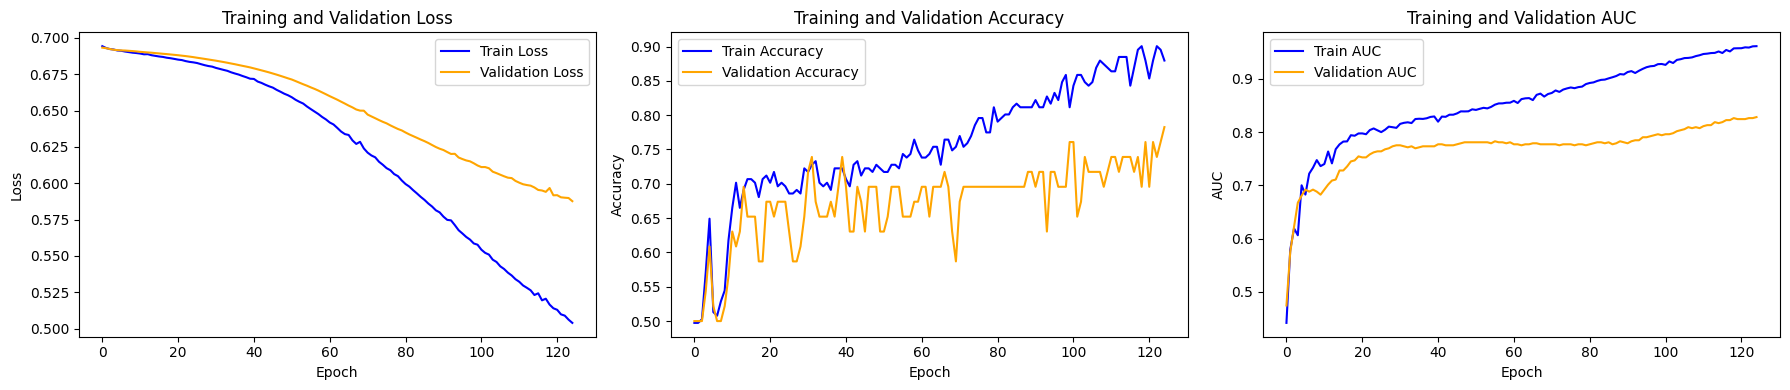

Training finished!
Test Accuracy: 1.0000
Test AUC: 1.0000


In [16]:
#### Block 4 ####
### Training and validation ###
import torch
import torch.nn as nn
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_max_pool
from torch_geometric.data import DataLoader
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# Set seed
torch.manual_seed(15706112877486103401)

# Network parameters
input_dim = 20  # Corresponds to amino acid OHE
hidden_dim = 64 # Neural network density
output_dim = 2  # Set model to binary classification

# Hyperparameters
num_epochs = 125
learning_rate = 0.001

# Define a GNN model
class MyGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MyGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.lin = Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index, batch):
        # Convert input tensor 'x' to Float data type
        x = x.float()
        
        # Apply the first graph convolution layer
        x = self.conv1(x, edge_index)
        x = x.relu()
    
        # Apply the second graph convolution layer
        x = self.conv2(x, edge_index)
        x = x.relu()
    
        # Perform graph-level pooling (e.g., global max pooling)
        x = global_max_pool(x, batch)
        x = self.lin(x)
        x = F.softmax(x, dim=1) 
    
        return x

# Initialize your GNN model
model = MyGNN(input_dim, hidden_dim, output_dim)

# Define batching
batch = next(iter(train_loader))
print(batch)

# Forward pass through the model
out = model(batch.x, batch.edge_index, batch.batch)

# Define optimization method
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Empty containers for loss and accuracy metrics
train_losses = []
val_losses = []

train_accuracies = []
val_accuracies = []

train_aucs = []  # New list to store training AUC values
val_aucs = []  # New list to store validation AUC values

## Training and validation loops ##
for epoch in range(num_epochs):
    epoch_train_loss = 0.0
    total_correct_train = 0
    total_samples_train = 0
    train_predictions = []  # New list to store training predictions
    train_labels_all = []  # New list to store true training labels
    
    # Training loop
    model.train()
    train_correct_count = 0  # Total number of correct predictions for the epoch
    train_total_count = 0  # Total number of samples for the epoch

    # Validation loop
    model.eval()
    val_loss = 0.0
    total_correct_val = 0
    total_samples_val = 0
    val_predictions = []  # New list to store predictions
    val_labels_all = []  # New list to store true labels
    
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
    
            labels = (batch.graph_y[:, 0] == 1).long()
    
            loss = F.cross_entropy(out, labels, reduction='sum')
            val_loss += loss.item()
    
            predicted_labels = out.argmax(dim=1)
            total_correct_val += (predicted_labels == labels).sum().item()
            total_samples_val += labels.size(0)
    
            # Store predictions and true labels for each batch
            val_predictions.extend(out[:, 1].cpu().numpy())  # Detach not needed for no_grad context
            val_labels_all.extend(labels.cpu().numpy())


    
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        out = model(batch.x, batch.edge_index, batch.batch)
        
        # Convert graph_y to binary labels
        labels = (batch.graph_y[:, 0] == 1).long()
        
        # Compute loss
        loss = F.cross_entropy(out, labels, reduction='sum')
        epoch_train_loss += loss.item()
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        predicted_labels = out.argmax(dim=1)
        train_correct_count += (predicted_labels == labels).sum().item()
        train_total_count += labels.size(0)
        
        # Store predictions and true labels for each batch
        train_predictions.extend(out[:, 1].detach().cpu().numpy())  # Detach the tensor before converting to numpy
        train_labels_all.extend(labels.detach().cpu().numpy())
    
    avg_train_loss = epoch_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)
    
    # Calculate training accuracy
    train_accuracy = train_correct_count / train_total_count
    train_accuracies.append(train_accuracy)
    
    # Calculate AUC-ROC for training data
    train_auc = roc_auc_score(train_labels_all, train_predictions)
    train_aucs.append(train_auc)
    
    
    # Calculate average validation loss
    avg_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(avg_val_loss)
    
    # Calculate overall validation accuracy using all true labels
    val_accuracy = total_correct_val / total_samples_val
    val_accuracies.append(val_accuracy)
    
    # Calculate AUC-ROC for validation data
    val_auc = roc_auc_score(val_labels_all, val_predictions)
    val_aucs.append(val_auc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - Train AUC: {train_auc:.4f} - Validation Loss: {avg_val_loss:.4f} - Validation Accuracy: {val_accuracy:.4f} - Validation AUC: {val_auc:.4f}")

# Plotting the training progress
plt.figure(figsize=(18, 4))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(train_aucs, label='Train AUC', color='blue')
plt.plot(val_aucs, label='Validation AUC', color='orange')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Training and Validation AUC')
plt.legend()

plt.tight_layout()
plt.show()

print("Training finished!")

### Test data ###
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from sklearn.metrics import accuracy_score, roc_auc_score

# Assuming you have your test data in a DataLoader called test_loader
# If you don't have one, create it similarly to how you created train_loader and val_loader.

# Set the model to evaluation mode
model.eval()

# Initialize variables for accuracy calculation
total_correct_test = 0
total_samples_test = 0

# Lists to store predictions and true labels for potential further analysis
test_predictions = []
test_labels = []
test_probabilities = []  # New list to store probabilities for AUC

# Iterate through the test DataLoader
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)  # Send data to GPU if available
        out = model(batch.x, batch.edge_index, batch.batch)
        
        # Convert graph_y to binary labels
        labels = (batch.graph_y[:, 0] == 1).long()
        
        # Calculate predictions
        predicted_labels = out.argmax(dim=1)
        
        # Accumulate the number of correct predictions and total samples
        total_correct_test += (predicted_labels == labels).sum().item()
        total_samples_test += labels.size(0)

        # Store predictions and true labels
        test_predictions.extend(predicted_labels.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
        test_probabilities.extend(out[:, 1].cpu().numpy())  # Store the probabilities for the positive class

# Calculate test accuracy
test_accuracy = accuracy_score(test_labels, test_predictions)

# Calculate test AUC
test_auc = roc_auc_score(test_labels, test_probabilities)

# Report the test accuracy and AUC
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")


In [20]:
import torch
torch.save(model.state_dict(), '#######.pth')
print("Model saved successfully!")

Model saved successfully!


In [21]:
# Initialize the model structure
model = MyGNN(input_dim, hidden_dim, output_dim)

# Load the saved model parameters
model.load_state_dict(torch.load('20240920_KRvsNR_125epoch.pth'))

# Make sure the model is in evaluation mode if you're using it for inference
model.eval()

MyGNN(
  (conv1): GCNConv(20, 64)
  (conv2): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)

Processing batch with 3 graphs
Explanation for graph ttmJ_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


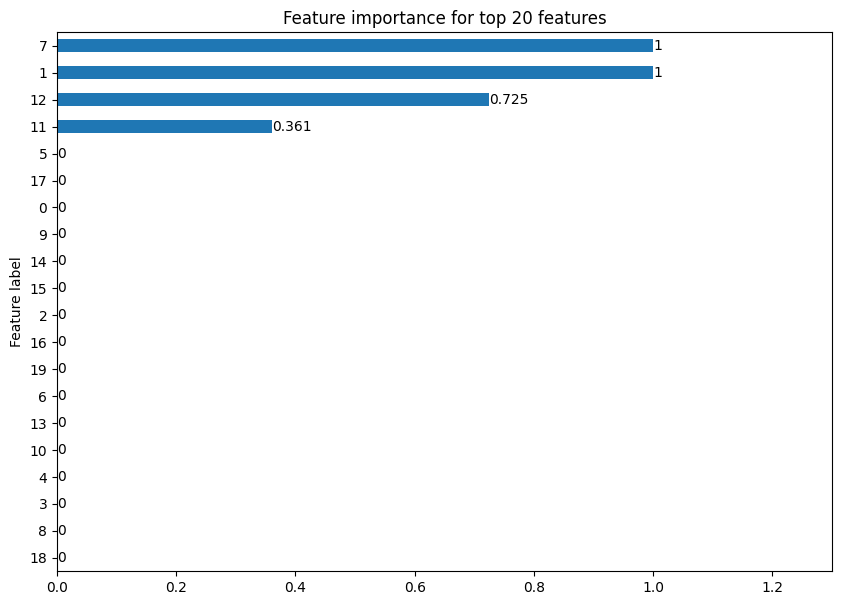

Explanation for graph acuAVI_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


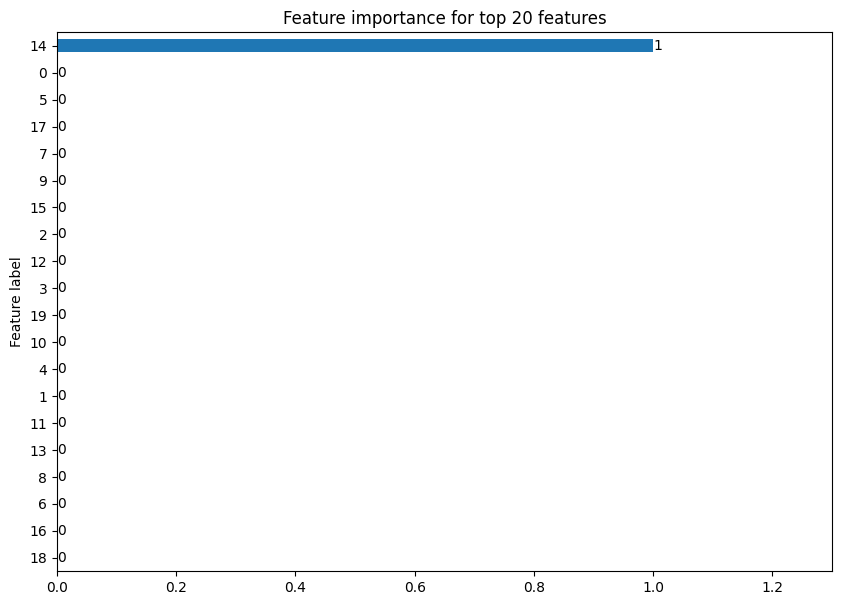

Explanation for graph nysI_Mod.4.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.5512e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


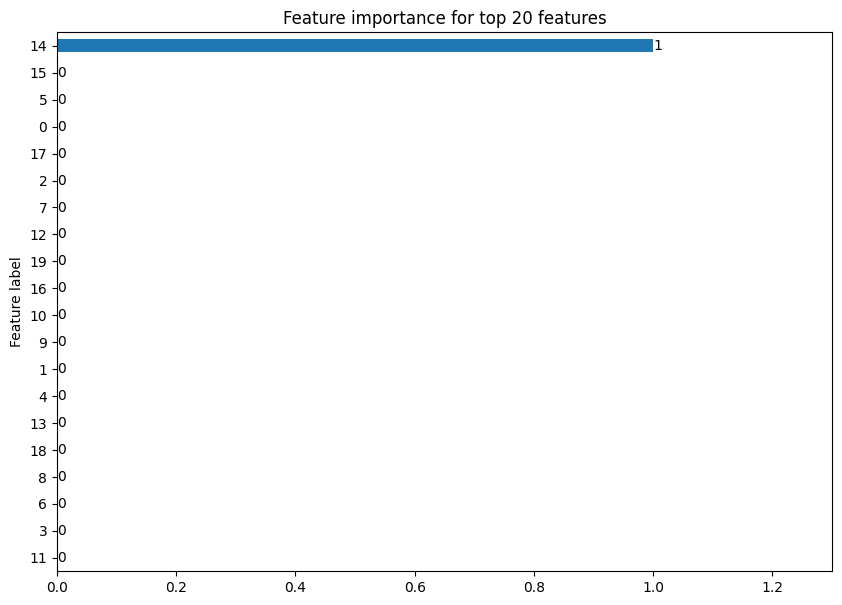

Processing batch with 46 graphs
Explanation for graph EbeB_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


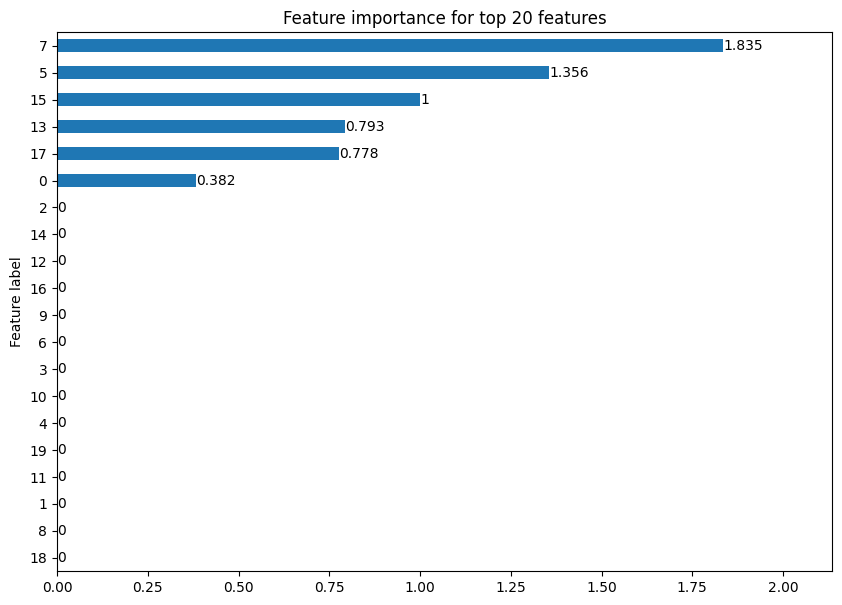

Explanation for graph npmB_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.4335e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


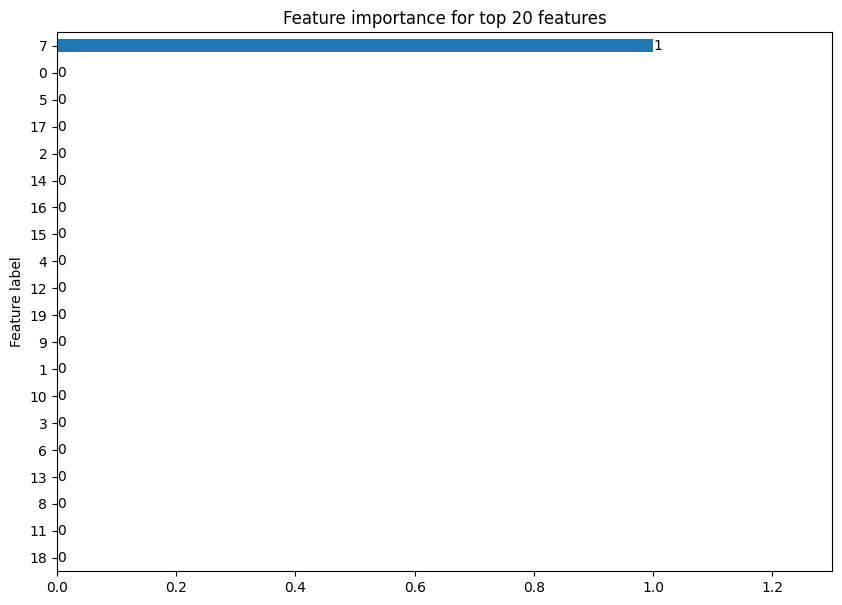

Explanation for graph cle1_Mod.3.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.9980e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


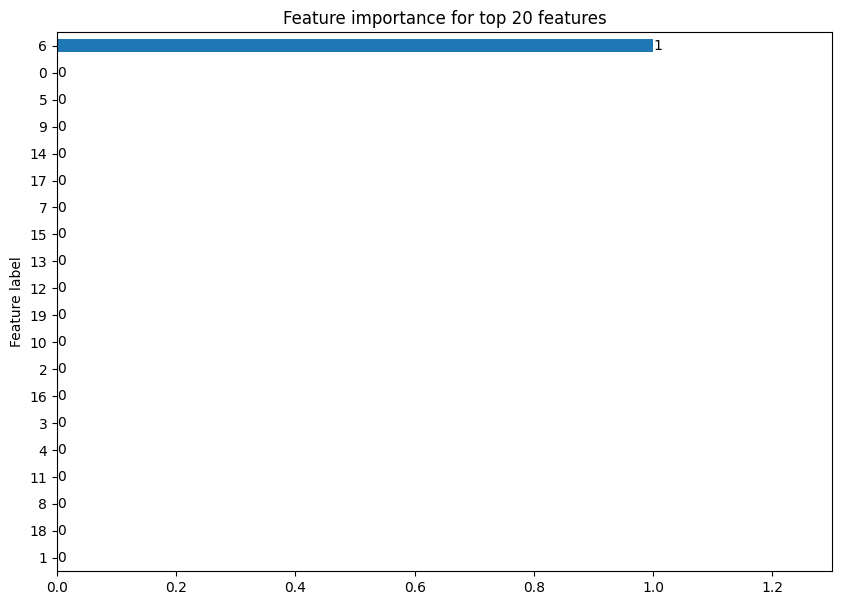

Explanation for graph natC_Mod.3.pdb_aligned: tensor([1., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


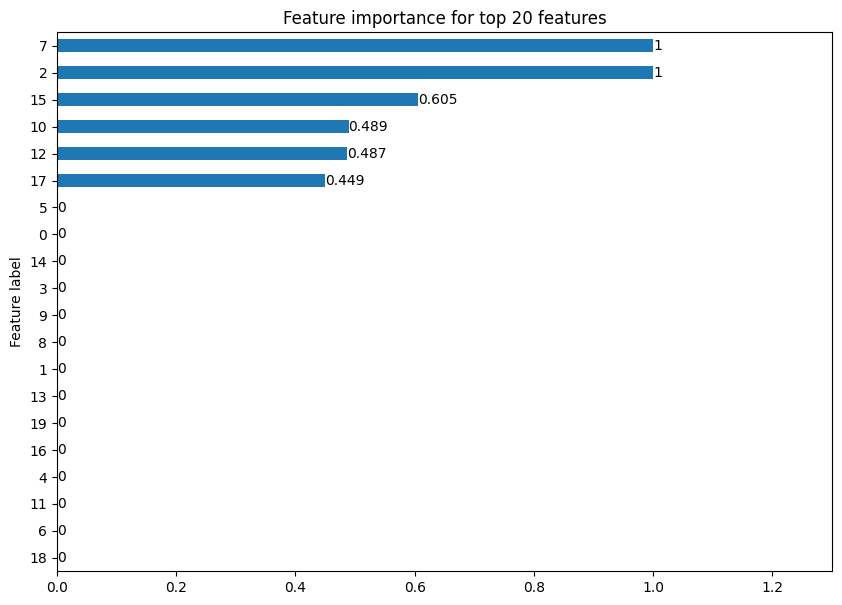

Explanation for graph mbcAII_Mod.1.pdb_aligned: tensor([4.1944e-11, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.8043e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


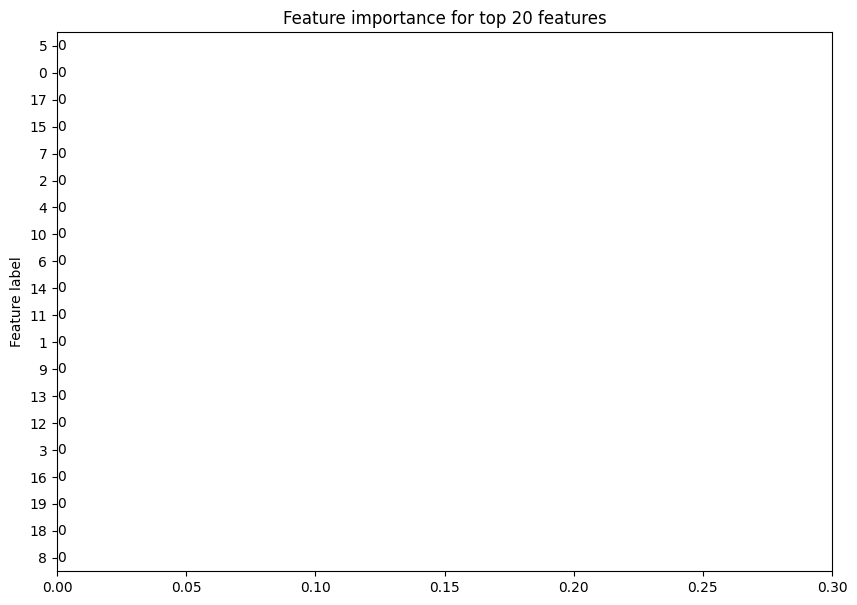

Explanation for graph ctaD_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.0285e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


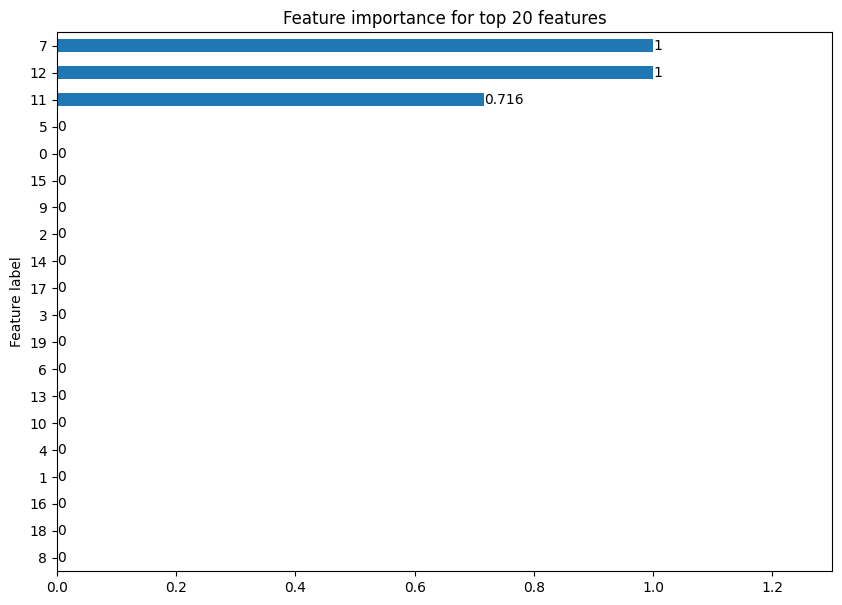

Explanation for graph lobA5_Mod.2.pdb_aligned: tensor([5.3514e-11, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.7555e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


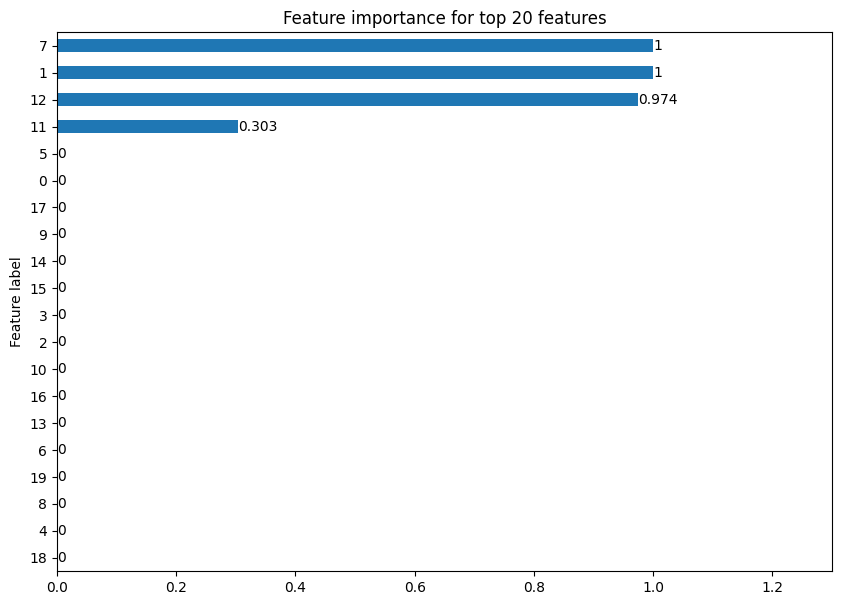

Explanation for graph nbrH_Mod.4.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


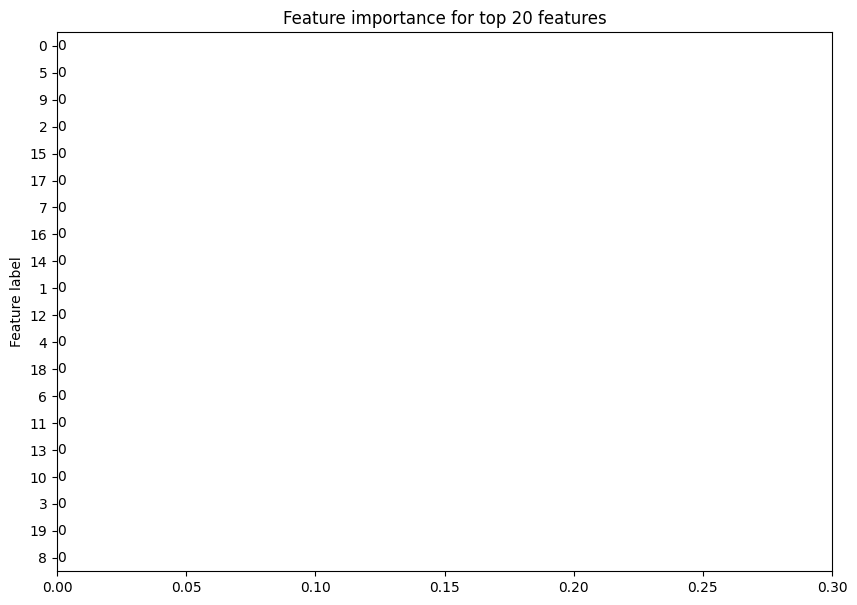

Explanation for graph ctaF_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.0154e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


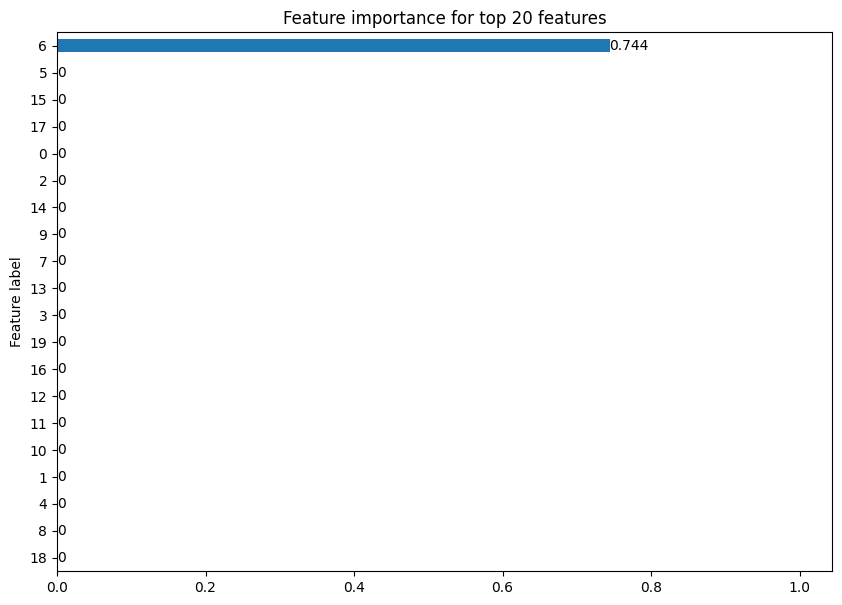

Explanation for graph fosA_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.0315e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


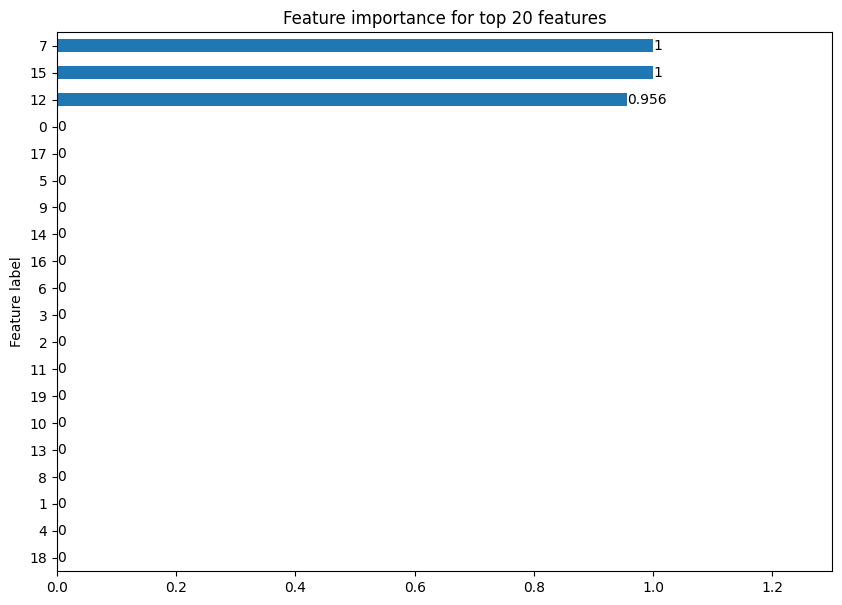

Explanation for graph divK_Mod.3.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.9386e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


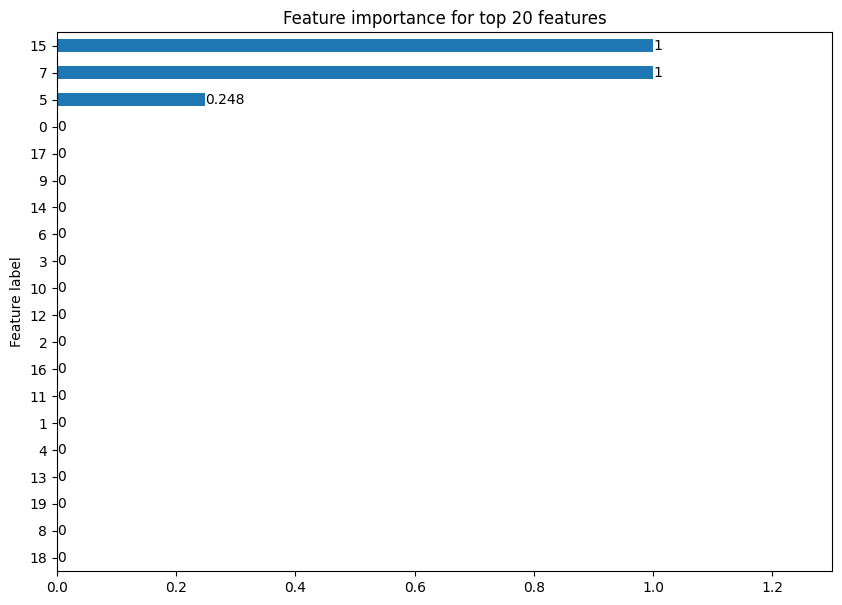

Explanation for graph lasAIII_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.9361e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


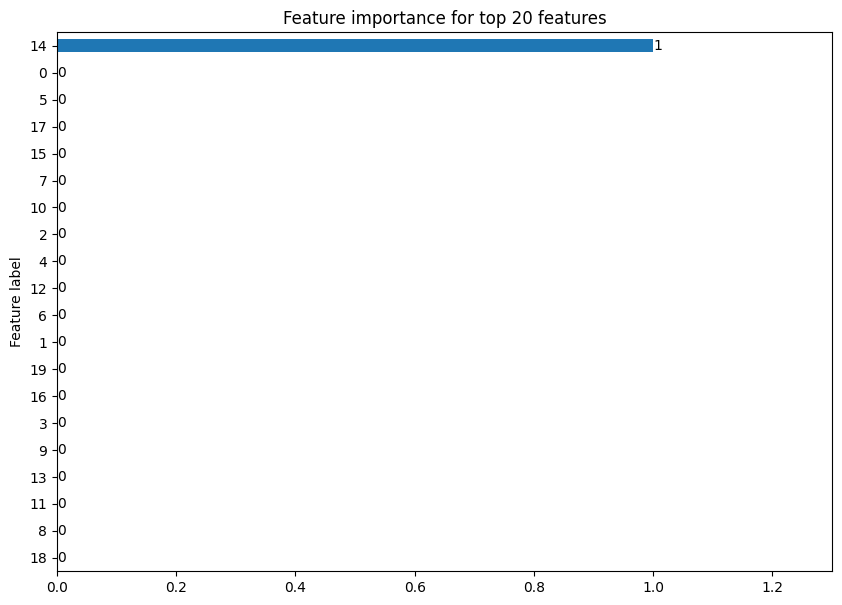

Explanation for graph cppB_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


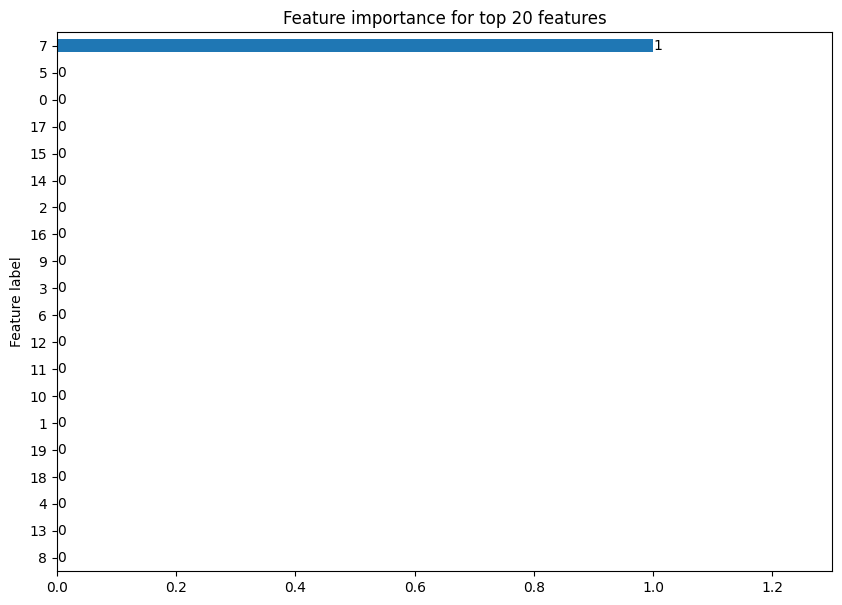

Explanation for graph spnD_Mod.1.pdb_aligned: tensor([4.5965e-11, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.1704e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


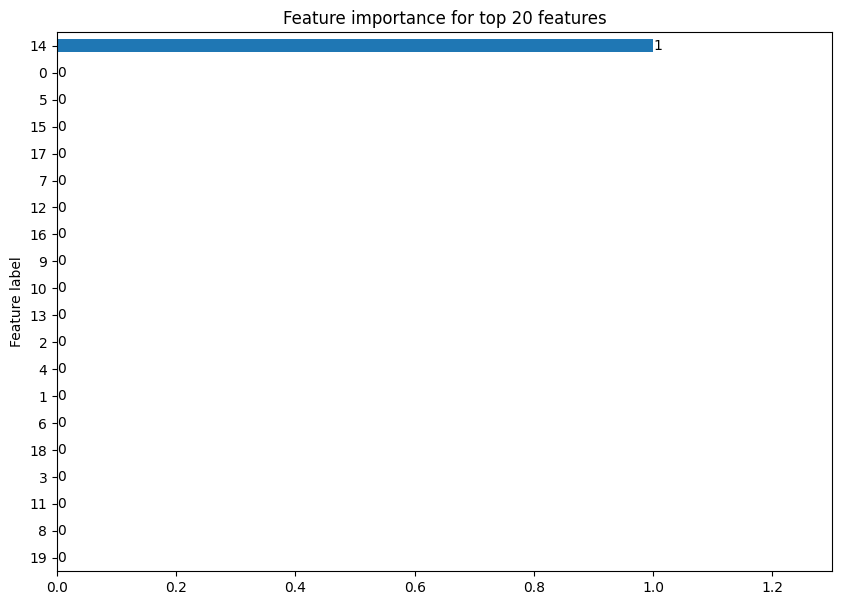

Explanation for graph BafAIV_Mod.2.pdb_aligned: tensor([6.1027e-11, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.5556e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


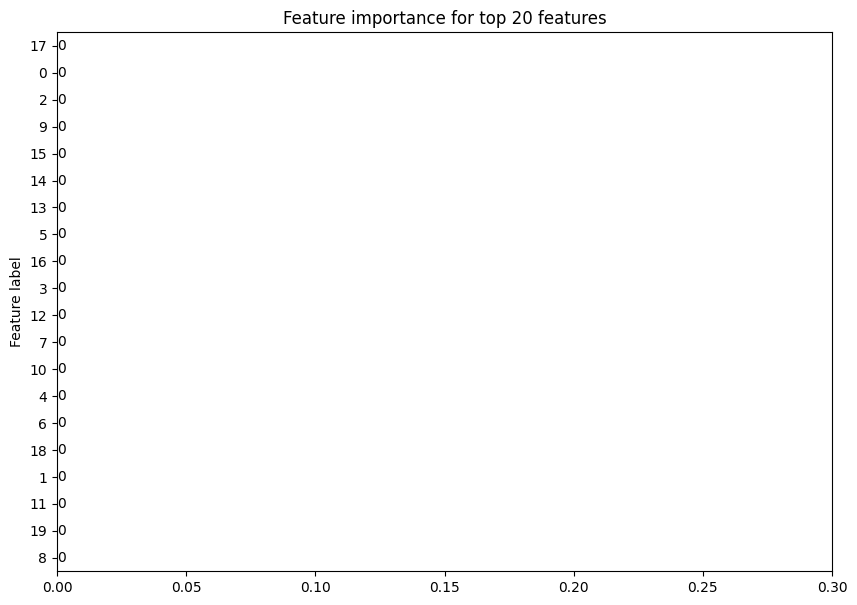

Explanation for graph pteA1_Mod.1.pdb_aligned: tensor([5.2167e-11, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


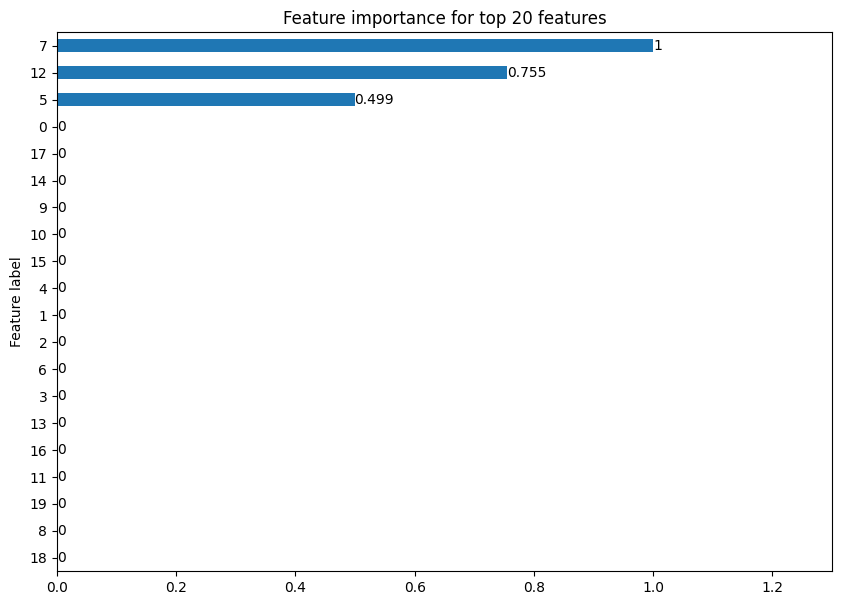

Explanation for graph tylG_Mod.2.pdb_aligned: tensor([5.8591e-11, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


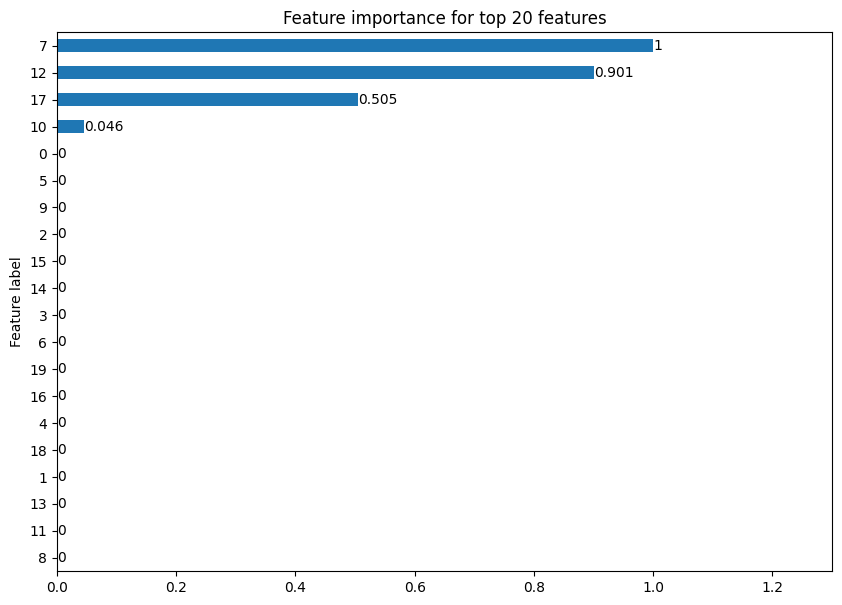

Explanation for graph megAI_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.2408e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


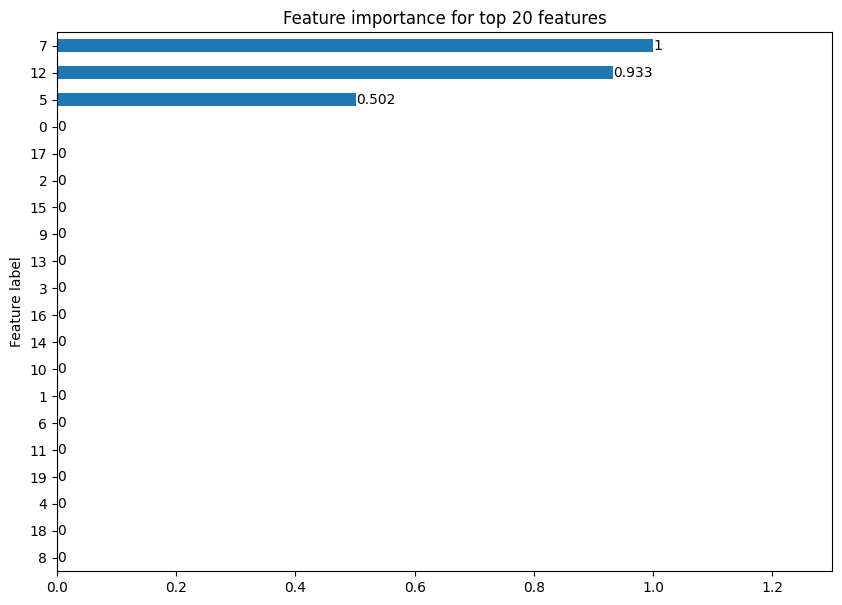

Explanation for graph aizG_mod.21.pdb_aligned: tensor([4.4213e-11, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


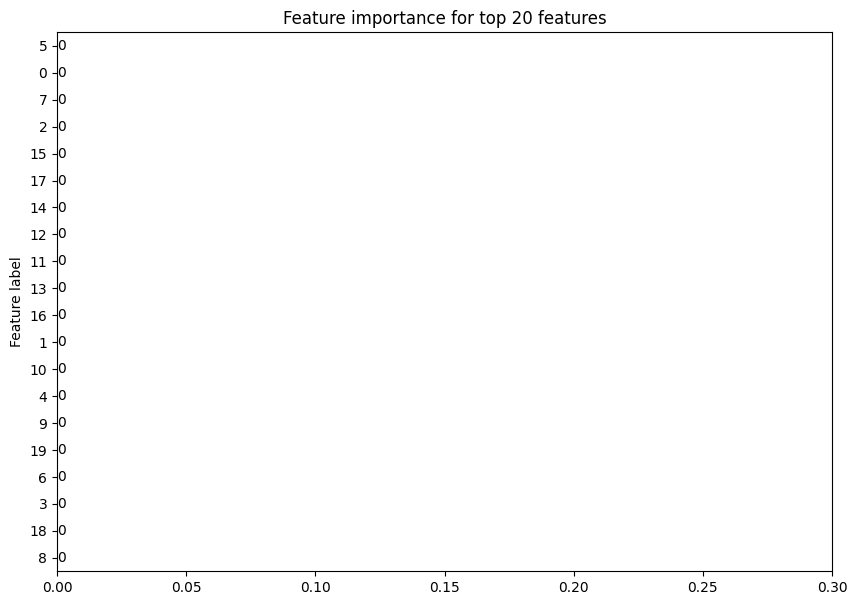

Explanation for graph merC_Mod.4.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


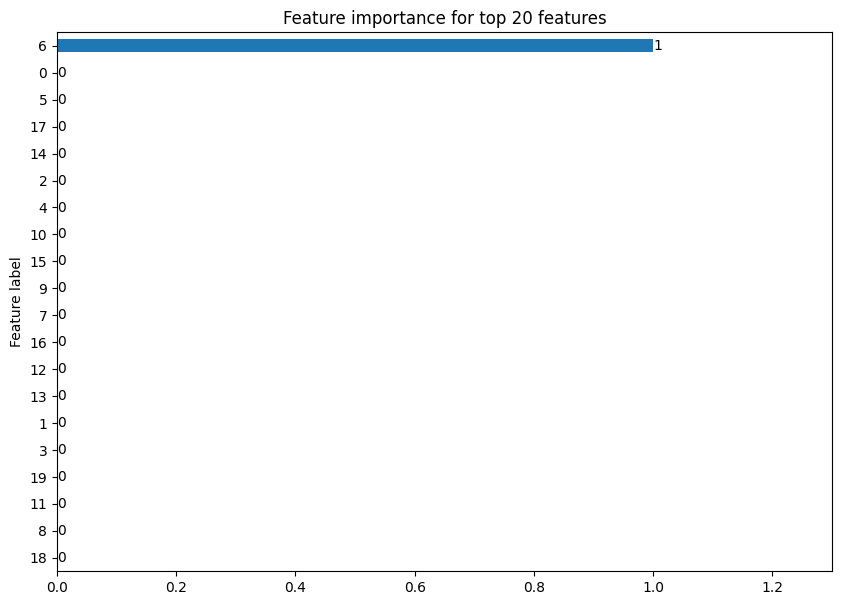

Explanation for graph megAIII_Mod.2.pdb_aligned: tensor([5.6377e-11, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.2459e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


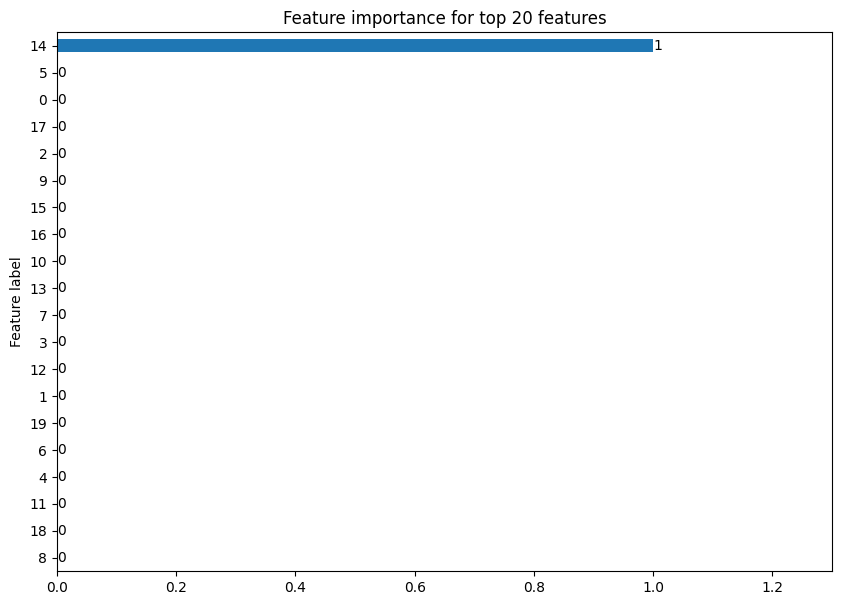

Explanation for graph NcmAI_Mod.1.pdb_aligned: tensor([0.0000e+00, 0.0000e+00, 3.8322e-11,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


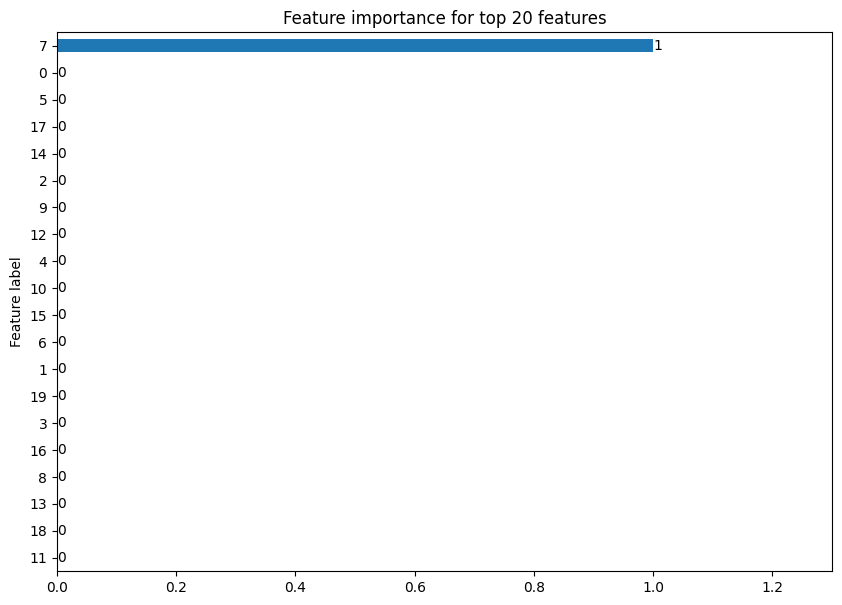

Explanation for graph PieA6_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


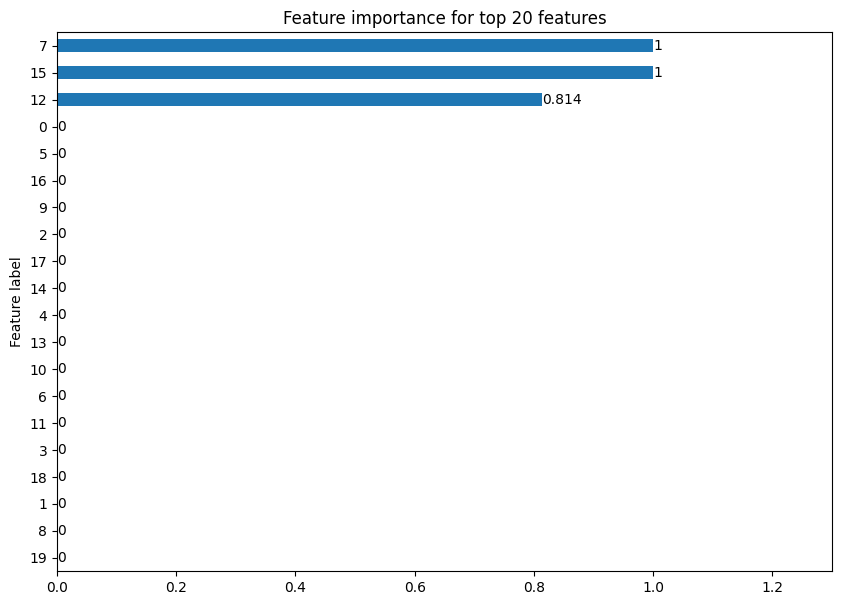

Explanation for graph ttmI_Mod.3.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


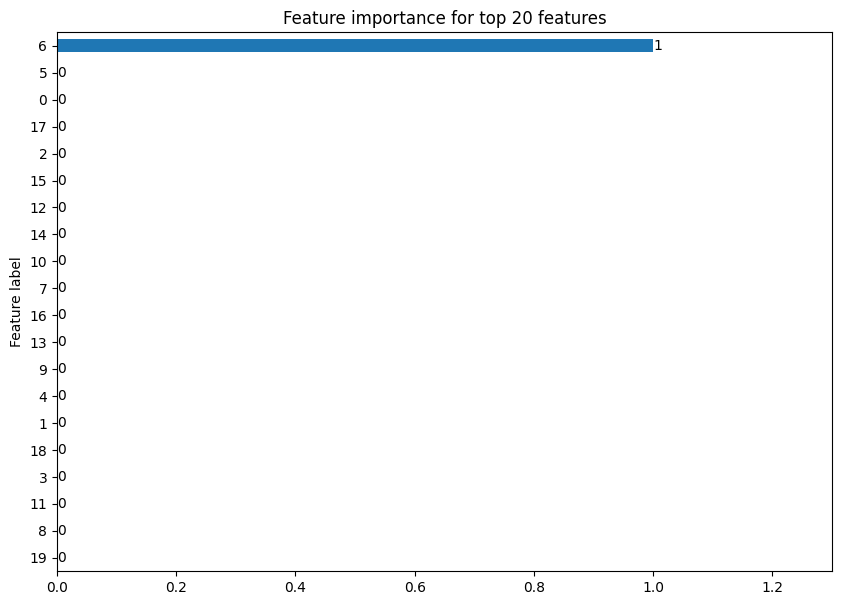

Explanation for graph chmGI_Mod.3.pdb_aligned: tensor([4.2495e-11, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.8087e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


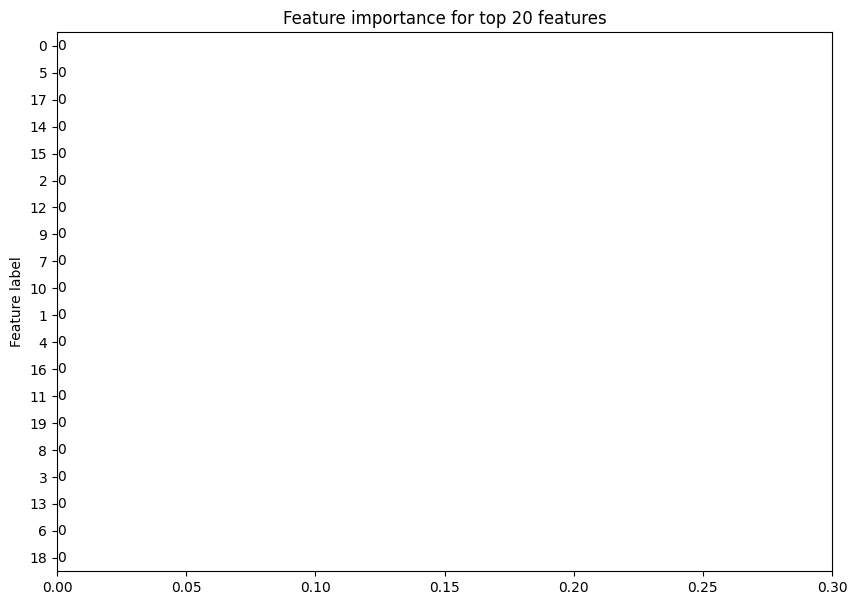

Explanation for graph nysI_Mod.3.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.5985e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


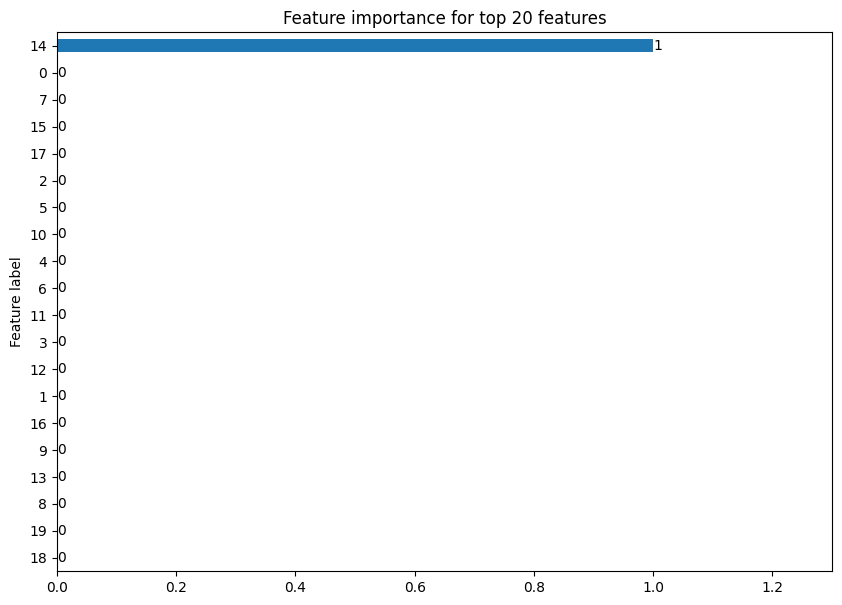

Explanation for graph olmA1_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


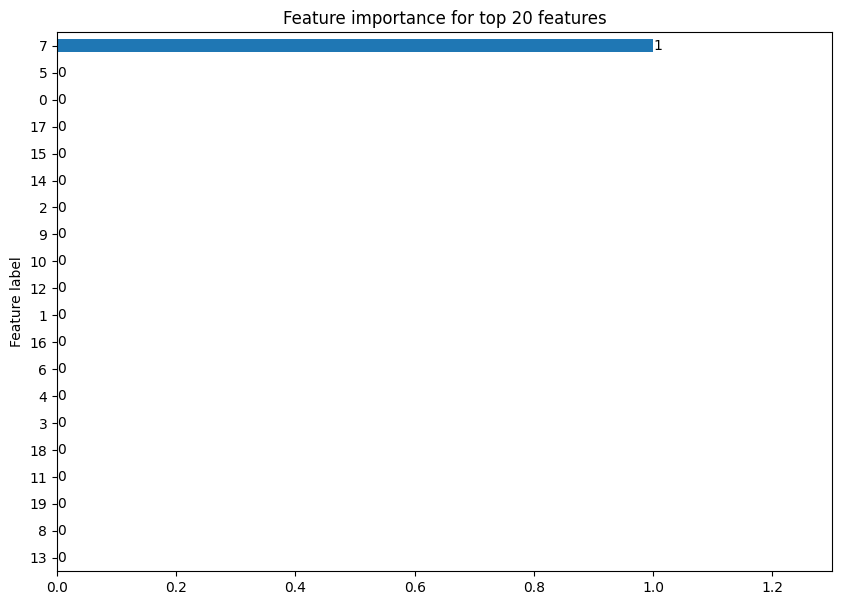

Explanation for graph spnC_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


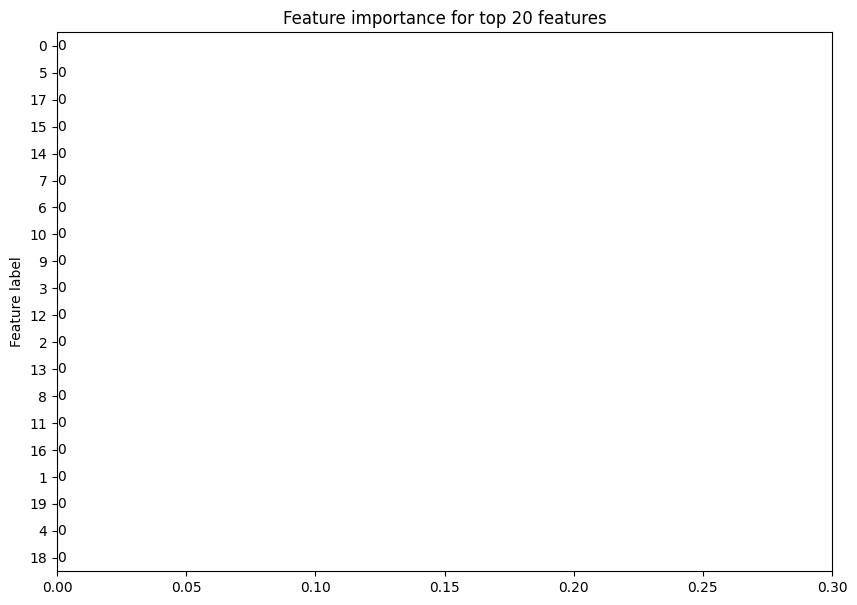

Explanation for graph aizC_mod.10.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.1129e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


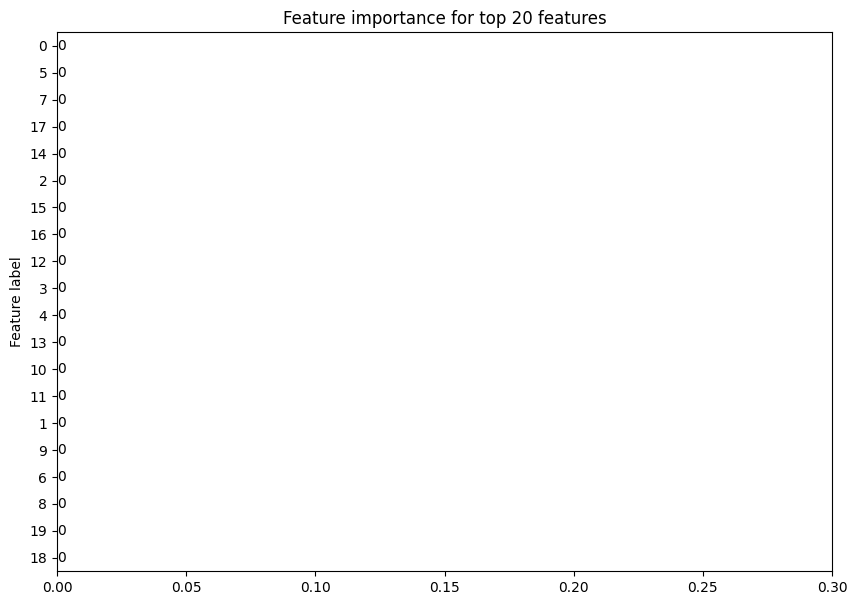

Explanation for graph slnA3_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


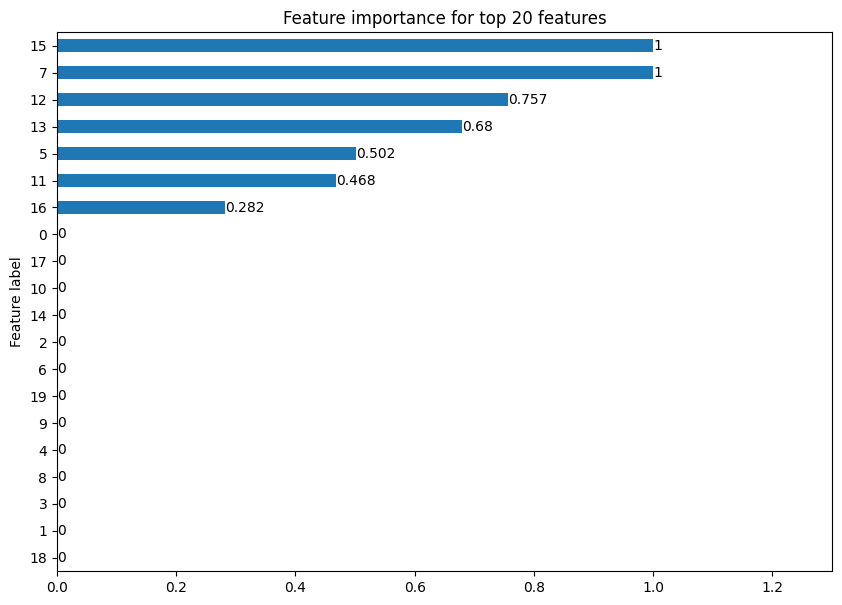

Explanation for graph ken16_Mod.3.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.5528e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


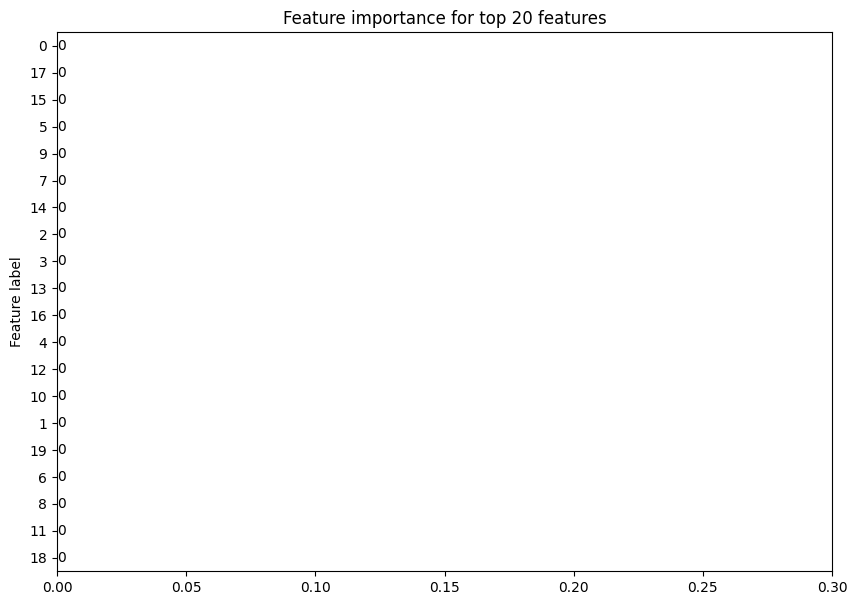

Explanation for graph cxmB_Mod.4.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


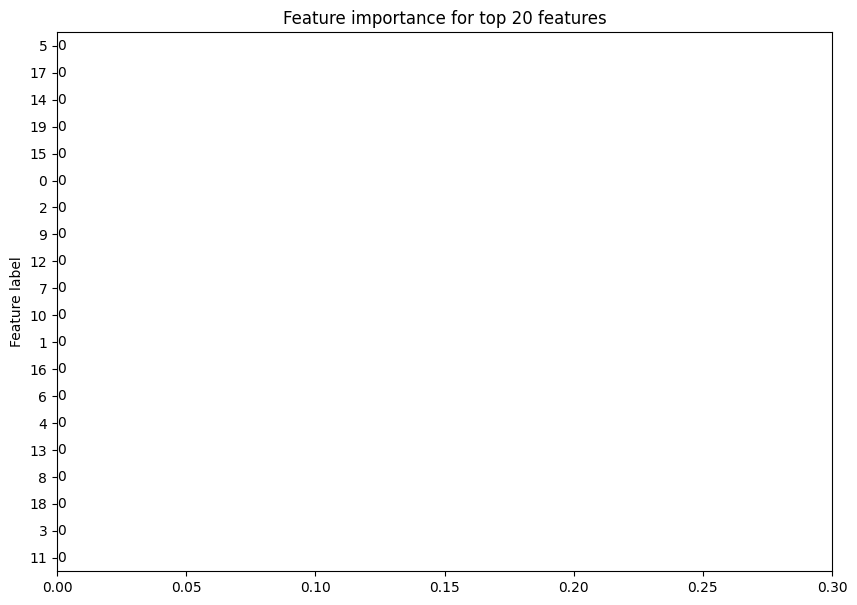

Explanation for graph pldAI_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


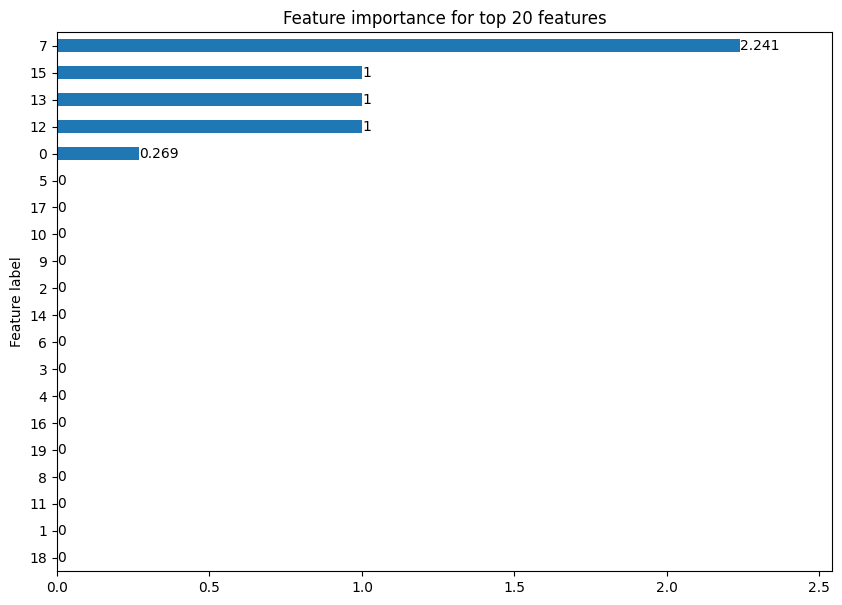

Explanation for graph megAII_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.1459e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


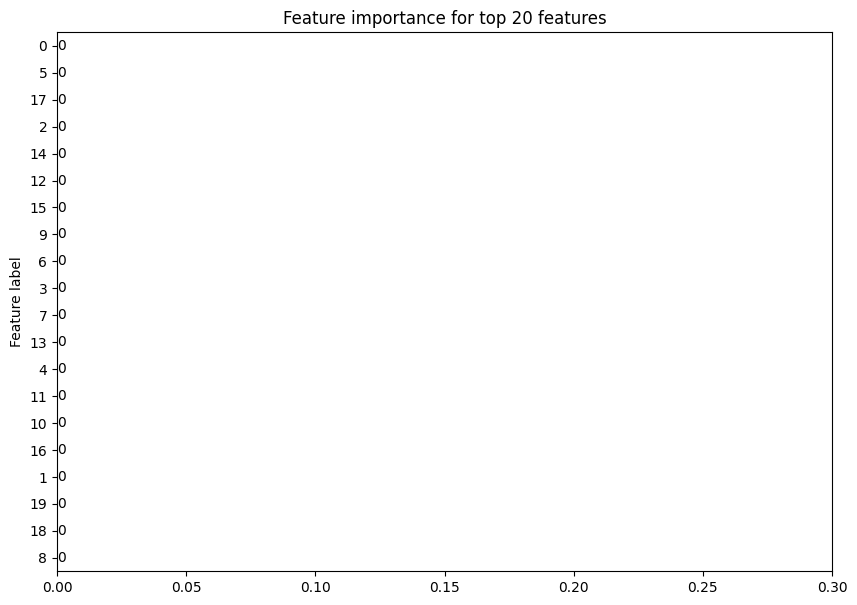

Explanation for graph leoB_Mod.3.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


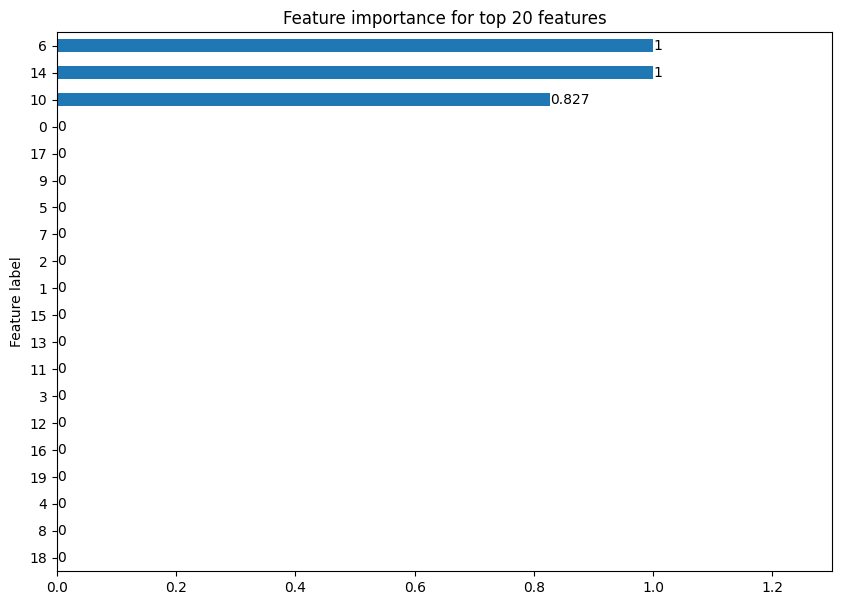

Explanation for graph azlG_Mod.15.pdb_aligned: tensor([6.2604e-11, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.1356e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


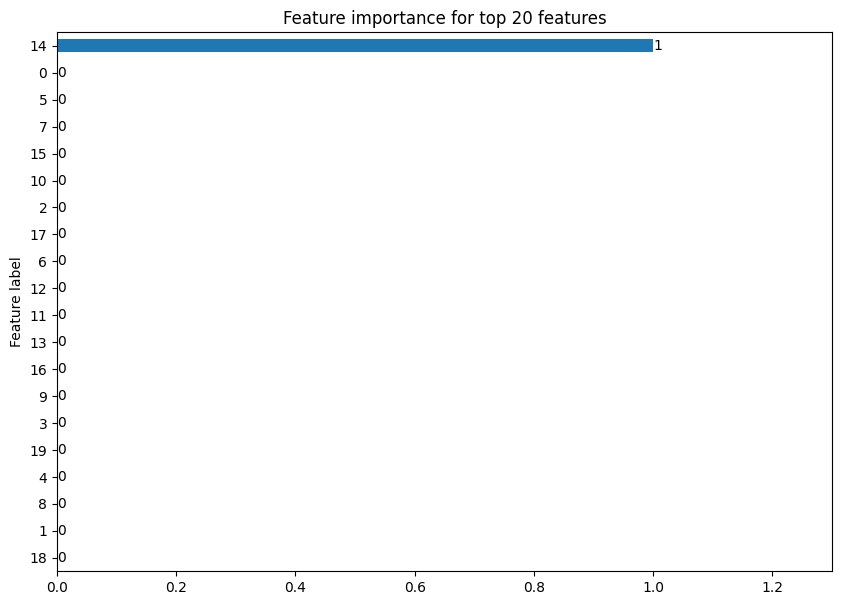

Explanation for graph slnA8_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.9474e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


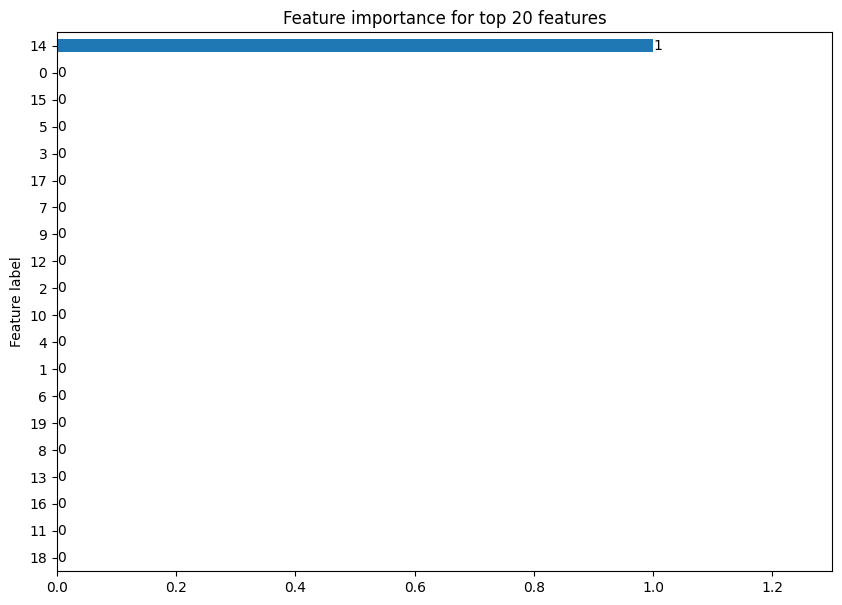

Explanation for graph asmC_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.2603e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


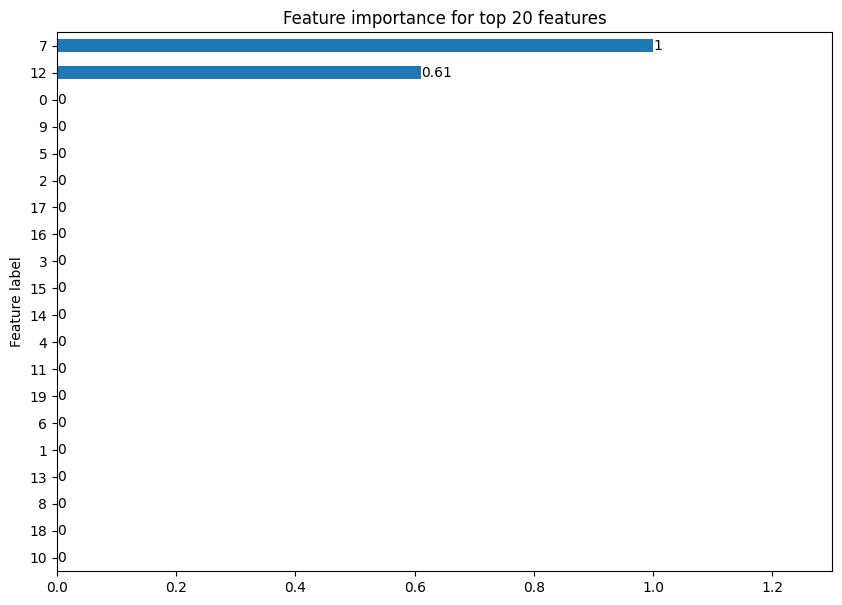

Explanation for graph hlsF_Mod.1.pdb_aligned: tensor([7.5214e-11, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [6.0285e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


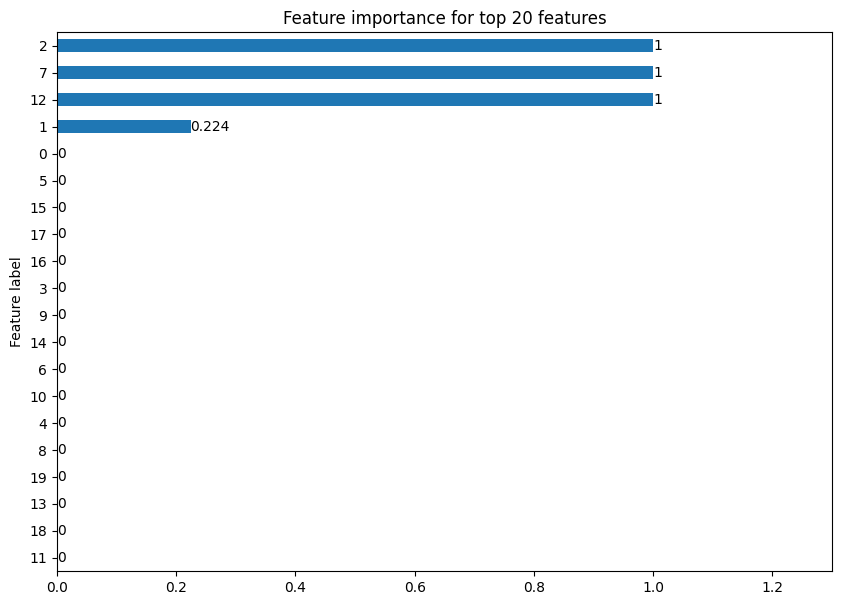

Explanation for graph ncdA_Mod.1.pdb_aligned: tensor([5.5725e-11, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 5.0231e-10, 0.0000e+00,
         0.0000e+00],
        [4.9963e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


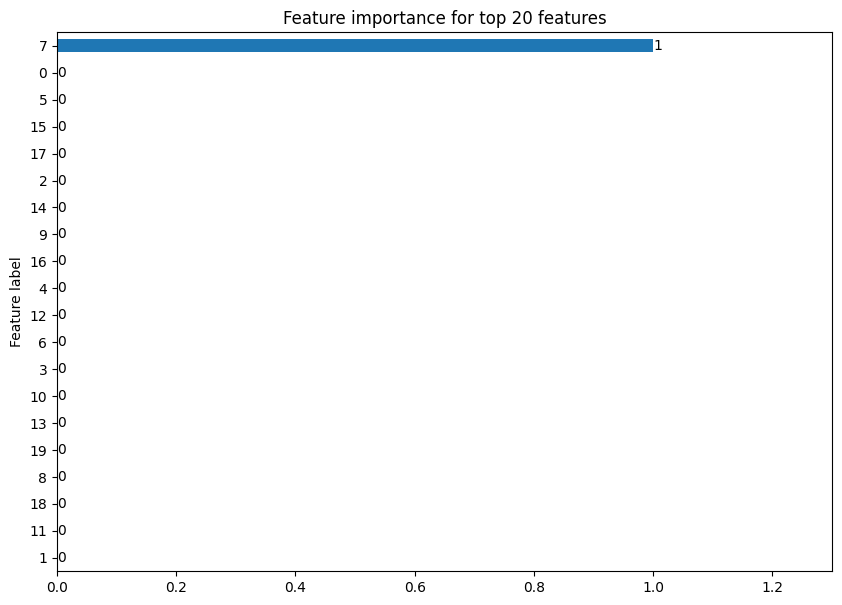

Explanation for graph almHI_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


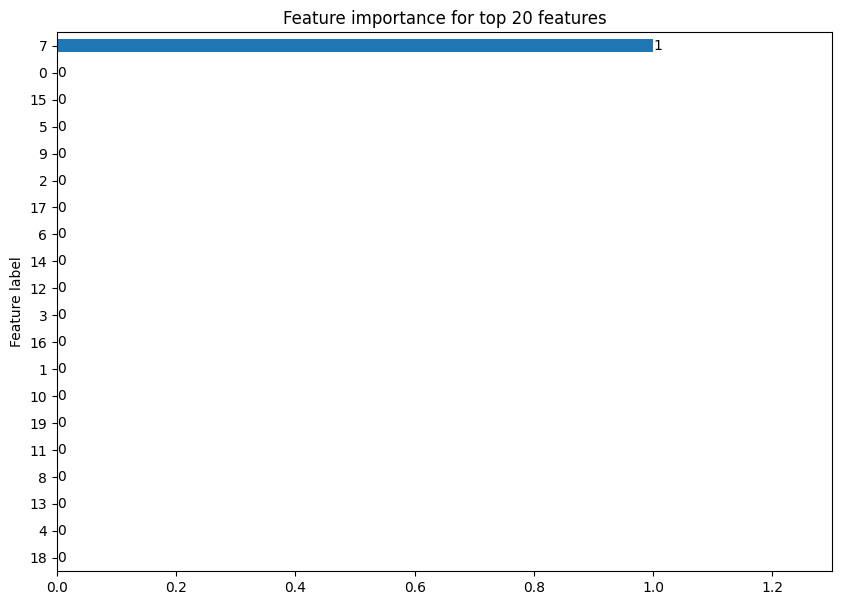

Explanation for graph plm1_Mod.1.pdb_aligned: tensor([4.4679e-11, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.1680e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


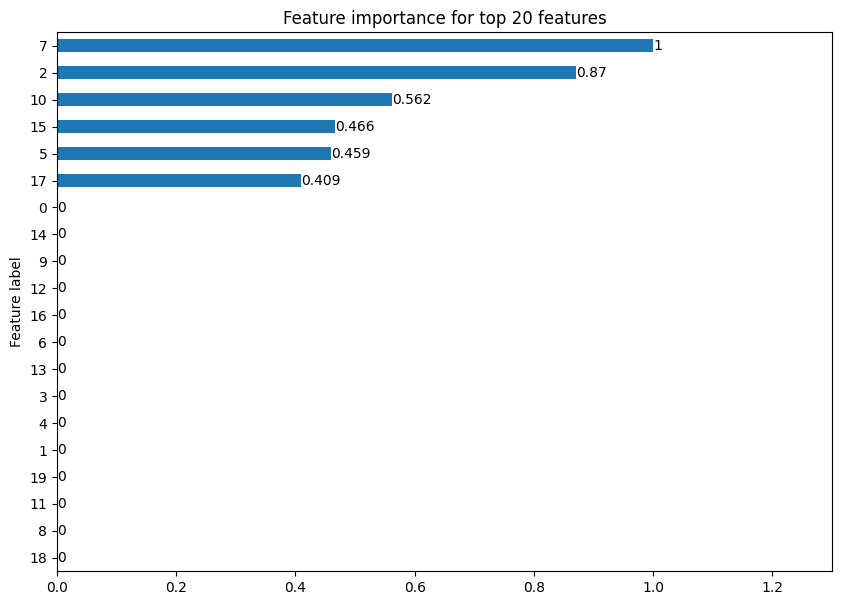

Explanation for graph fscE_Mod.3.pdb_aligned: tensor([5.1604e-11, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.1320e-10, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.1242e-10, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


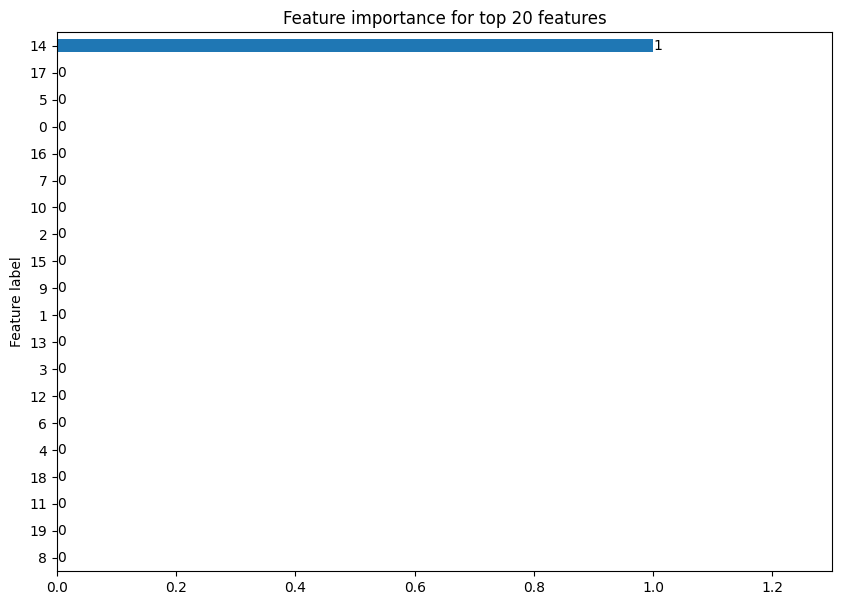

Explanation for graph ttnA_Mod.6.pdb_aligned: tensor([5.5043e-11, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.5561e-10, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


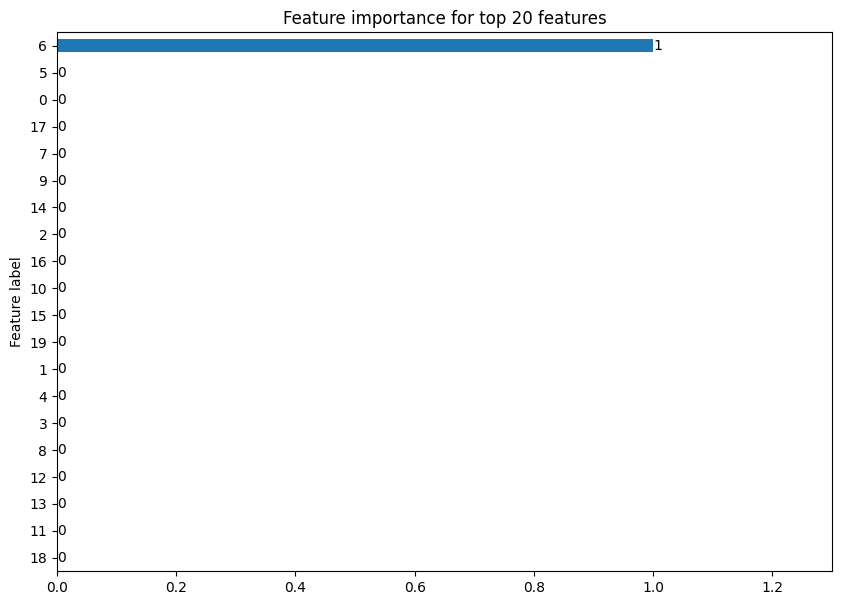

Explanation for graph leoA_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.6444e-10, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


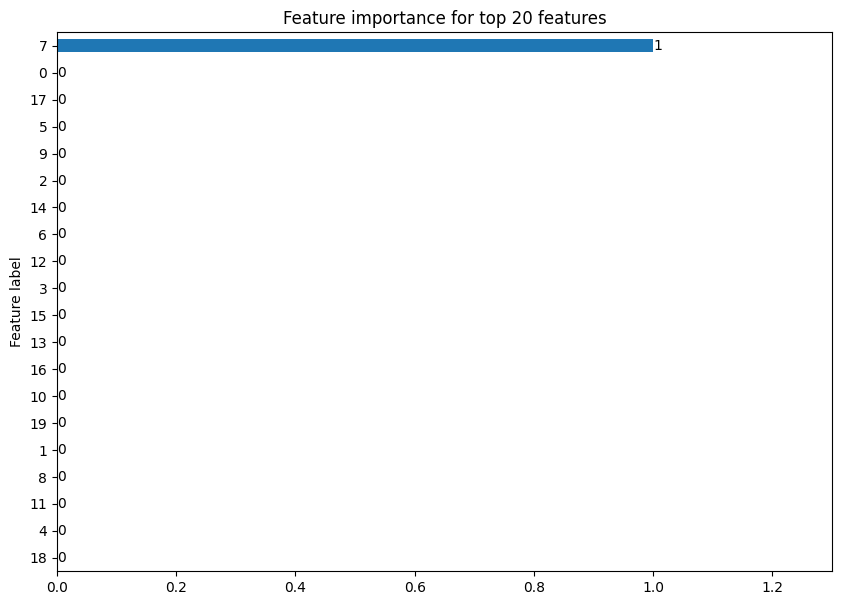

Explanation for graph SeEryAI_Mod.1.pdb_aligned: tensor([4.1849e-11, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 3.6768e-10, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


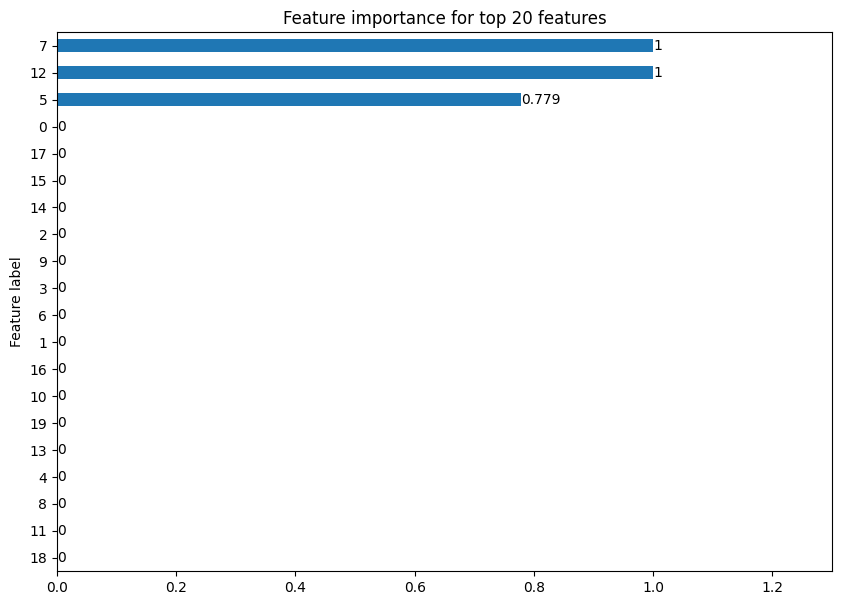

In [22]:
#### Block 5 ####
### Explainer loop ### 
from torch_geometric.data import Data
from torch_geometric.explain import Explainer, GNNExplainer
import torch

import numpy as np
import os
import re
from sklearn.model_selection import train_test_split
import pandas as pd

# Specify the folder where you want to save the output files
output_folder = "/home/q31032mw/Dropbox (The University of Manchester)/Max/17_ML_Project/Rank_1/20240920_binaryclass_KS_dimers_KRandNR_graphViz/"

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Iterate through your loader
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=100000),
    explanation_type='phenomenon', # options are model (describes the model) or phenomenon (describes why descision was made for input and input label)
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='graph',
        return_type='raw', 
    ),
)
# Iterate through your loader
loader = test_loader
for batch in loader:
    # Print some information about the current batch
    print(f"Processing batch with {batch.num_graphs} graphs")

    # Generate explanation for each graph in the batch
    for i in range(batch.num_graphs):
        # Extract data for the i-th graph in the batch
        graph_data = batch[i]

        # Create a new Data object
        data = Data(
            edge_index=graph_data.edge_index,
            node_id=graph_data.node_id,
            coords=graph_data.coords,
            name=graph_data.name,
            num_nodes=graph_data.num_nodes,
            x=graph_data.x.view(len(graph_data.node_id), 20),
        )

        # Extract the graph-level label for the current graph
        target_values = graph_data.graph_y.tolist()
        target = torch.tensor(target_values).float()

        # Generate explanation for the node at index `10`:
        explanation = explainer(x=data.x, edge_index=data.edge_index, batch=data.batch, target=target)

        # Print or do something with the explanation for the current graph
        print(f"Explanation for graph {graph_data.name}:", explanation.edge_mask, explanation.node_mask)

        # Optionally, you can visualize the feature importance for each graph
        explanation.visualize_feature_importance(top_k=20)

        # Save the output of visualize_graph to a file in the specified folder
        graphviz_output = explanation.visualize_graph(path=os.path.join(output_folder, f"graph_output_{graph_data.name}.pdf"), backend="graphviz")
        
# Iterate through your loader
loader = val_loader
for batch in loader:
    # Print some information about the current batch
    print(f"Processing batch with {batch.num_graphs} graphs")

    # Generate explanation for each graph in the batch
    for i in range(batch.num_graphs):
        # Extract data for the i-th graph in the batch
        graph_data = batch[i]

        # Create a new Data object
        data = Data(
            edge_index=graph_data.edge_index,
            node_id=graph_data.node_id,
            coords=graph_data.coords,
            name=graph_data.name,
            num_nodes=graph_data.num_nodes,
            x=graph_data.x.view(len(graph_data.node_id), 20),
        )

        # Extract the graph-level label for the current graph
        target_values = graph_data.graph_y.tolist()
        target = torch.tensor(target_values).float()

        # Generate explanation for the node at index `10`:
        explanation = explainer(x=data.x, edge_index=data.edge_index, batch=data.batch, target=target)

        # Print or do something with the explanation for the current graph
        print(f"Explanation for graph {graph_data.name}:", explanation.edge_mask, explanation.node_mask)

        # Optionally, you can visualize the feature importance for each graph
        explanation.visualize_feature_importance(top_k=20)

        # Save the output of visualize_graph to a file in the specified folder
        graphviz_output = explanation.visualize_graph(path=os.path.join(output_folder, f"graph_output_{graph_data.name}.pdf"), backend="graphviz")
